<a href="https://colab.research.google.com/github/JoDeMiro/Micado-Research/blob/main/ML_Auto_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Micado Auto Scale Research

Ebben a felskálázási adatok elemzésével foglalkozom.

Ez az interkatív bemutató arra van, hogy a válotzók közötti összefüggéseket jobban átlásssam, elemezzem, az esetleges anomáliákat rögtön kiszúrjam.

A playground részben a rendszer alapját adó neuráli háló beállításaival lehet játszani és megfigyelni, hogy milyen hatással van a rendszer teljesítményére.

<a name="tartalom"></a>

## Tartalom

Bevezetés

> [Empty](#empty)<br>
> [Play Ground](#play_ground)<br>
> [SandBox](#sandbox)<br>
> [Before After](#beforeafter)<br>
> [Szintetikus adatok generálása](#szintetikus_adatok)<br>
> [Irodalom](#irodalom)<br>
> [ToDo](#todo)<br>


## Bevezető gondolat

Összességében az egésszel kapcsolatban van egy hatalmas kérdőjel.

Tulajdonképpen két paradigma van.

Az egyik - nem az enyém - így néz ki:

Egyszerűen becsüjük meg azt, hogy az adott szenzoros adatok alapján mi legyen a döntés kimenetele (fel, le, semmi). Akkor hoztunk jó döntést, ha valamilyen metrika alapján valamilyen költséget minimalizáltunk, vagy maximalizáltunk. Például, ha egy döntéssel sikerült közelebb kerülni a záróvonalhoz, vagyis az út közepére. Vagy az az autó a lehető legmeszebb jutott el anélkül, hogy érintette volna a falat és lehetőleg a leggyorsabban is.

A másik - amin én dolgozom - viszont egy plusz lépéssel egészül ki és ettől sokkal bonyolultabb. Hogy van-e létjogosultsága az ennek a kisérletnek a lényege.

Vannak szenzoros adataink, ami alapján hozunk egy döntést. Eddig olyan mint a máisik, de az érdemi különbség a módszerben és a tanulás folyamatában van.

A szenzoros adatokból megbecsüljük azt, hogy mennyire vagyunk jók és nem azt becsüljük, hogy mit kéne tenni!

Ha nem vagyunk jók akkor egy második modell segítségével csinálunk valamilyen lépést, amitől azt várjuk, hogy jók leszünk.

És itt jogosan merül fel a kérdés, hogy de miért nem az első módszert alkalmazzuk és erre most még én sem tudom a választ pontosan megadni. De röviden erről szól ez a kutatás.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

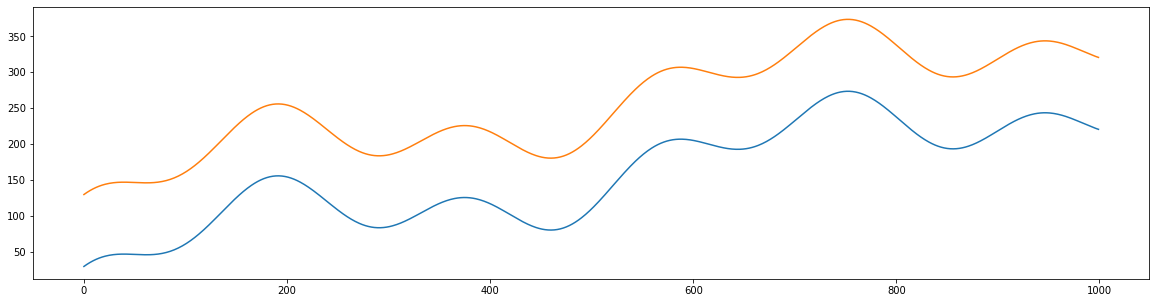

In [2]:
distance   = np.arange(0, 1000, 1)
road       = 100
wall_left  = 30*(np.sin(distance/180)) + distance * 0.3 + 30 * np.cos(distance/30) + 50 * np.sin(distance/90)
wall_right = wall_left + road

plt.figure(figsize=(20,5)); plt.plot(distance, wall_left); plt.plot(wall_right); plt.show()

In [3]:
class Road():
  def __init__(self):
    self.distance   = np.arange(0, 1000, 1)
    self.road       = 100
    self.wall_right = 30*(np.sin(self.distance/180)) + self.distance * 0.3 + 30 * np.cos(self.distance/30) + 50 * np.sin(self.distance/90)
    self.wall_left  = self.wall_right + self.road

  def show(self):
    fig, ax = plt.subplots(figsize=(20,5)); ax.set_ylim(0, 400); ax.plot(self.wall_left); ax.plot(self.wall_right);
    return fig, ax


In [4]:
class NeuralNetwork():
  def __init__(self):
    self.mlp = MLPRegressor(hidden_layer_sizes=(4,),
                           max_iter=5,
                           activation='relu', # tanh, relu, logistic
                           solver="lbfgs",
                           learning_rate="constant",
                           learning_rate_init=0.01,
                           alpha=0.01,
                           verbose=False,
                           momentum=0.9,
                           early_stopping=False,
                           tol=0.00000001,
                           shuffle=False,
                           n_iter_no_change=20,
                           random_state=1234)

In [156]:
class Car():
  def __init__(self, road, mlp):
    self.road = road
    self.x = 20
    self.y = (self.road.wall_left[0] + self.road.wall_right[0])/2
    self.sight = 100           # ennyit lát előre

    self.y_history  = []
    self.x_history  = []
    self.y_center   = []
    self.y_distance = []
    self.mlp        = mlp
    self.regression = LinearRegression()
    self.sensor_center = []
    self.sensor_left   = []
    self.sensor_right  = []
    self.before  = []
    self.after   = []

  def calculate_distances(self):
    # ha bármikor kevesebb a faltól mért távolsága bármelyik szenzoron akkor a szenzorokon mért távolság is ennyi lesz

    i = self.x; d = 0
    while(i < self.x + self.sight):
      i += 1; d += 1
      self.distance_center_from_wall = d
      if(int(self.road.wall_left[i]) == self.y or int(self.road.wall_right[i]) == self.y):
        print('Distance center = ', self.distance_center_from_wall)
        break
    
    i = self.x; d = 0
    while(i < self.x + self.sight):
      i += 1;  d += 1
      self.distance_left_from_wall = d
      if(int(self.road.wall_left[i]) < self.y + d):
        print('Distance from left wall = ', self.distance_left_from_wall)
        break

    i = self.x; d = 0
    while(i < self.x + self.sight):
      i += 1; d += 1
      self.distance_right_from_wall = d
      if(int(self.road.wall_right[i]) > self.y - d):
        print('Distance from right wall = ', self.distance_right_from_wall)
        break

    #ki kell kalkulálni a tényleges távolságot a ball és a jobb faltól
    # mert ezekre fogom tanítani a neurális hálót, ahol ezeket becsüljük
    # és a bemeneti változó a 3 szenzorból érkező adat lesz.
    # valójában jobb lenne, ha valami agregált számot csinálnék mondjuk
    # a felső faltol vett távolság és az alsótól vett távolság hányadosa

    self.felso = abs(self.road.wall_left[self.x] - self.y)
    self.also  = abs(self.road.wall_right[self.x] - self.y)
    print('tavolsagra van most a felsőtől = ', self.felso)
    print('tavolsagra van most az alsótól = ', self.also)
    # mérjük meg a felső és alsó közötti távolságot és egyszerűen vonjuk ki felsőből (vagy adjuk hozzá az alsóhoz) ->
    #  ez lesz a középpont. Az ettől mért távolságot tegyük egy listába. Ez az az érték amit a neurális hálónak majd becsülnie kell.
    road_center = (self.road.wall_left[self.x] + self.road.wall_right[self.x]) / 2
    self.y_distance.append(road_center - self.y)
    self.sensor_left.append(self.distance_left_from_wall)
    self.sensor_center.append(self.distance_center_from_wall)
    self.sensor_right.append(self.distance_right_from_wall)

  def run(self):
    for i in range(0, 120, 1):
      self.calculate_distances()
      self.plot()
      self.x = i
      if( i >= 12 ):
        if( i % 3 == 0 ):                   # 1. számú tanulás. Mi a kapcsolat a szenzoros adatok és aközött, hogy az út melyik részén van az autó (micadoban ez az NN)
          X = np.array([self.sensor_left, self.sensor_center, self.sensor_right]).T
          y = np.array([self.y_distance]).T
          print(X.shape)
          print(y.shape)
          self.regression.fit(X, y)
        if( i % 3 == 1 ):                   # 2. az 1. pontban megtanult modell alapján teszünk egy becslést - tulajdonképpen ezzel mérem az 1. modell jóságát, ez a lépés ezt szolgálja
          X = np.array([self.sensor_left, self.sensor_center, self.sensor_right]).T
          _X = np.array([X[-1,:].reshape(-1,1)])
          _X = np.array([X[-1,:]])
          print('actual _X = ', _X)
          predicted = self.regression.predict(_X)
          print('actual predicted = ', predicted)

        # most jön az, hogy véletlenszerűen kell egyet ugrania fel, vagy le
        # ez felel meg a before after dologonak
        # az így létrejött adatokat is el kell tárolni úgy mint
        # mi volt a szezoros adat before
        # mi lett a szenzoros adat after
        # mi volt az y before, mi lett az y after
        # mivel mindíg egyet fogunk csak lépni, ezért a dif mindíg egy lesz
        # de ezt számítani kell, mivel a későbbiek folyamán lehet, hogy többet is fog lépni

        if( i % 3 == 2 ):                   # 3. véletlenszerűen változtatok az autó pozicióján -> ebből állnak elő a before after adatok
          if( i % 2 == 0 ):                           # Minden második lépésben fel (valójában minden 6-ik lépésben)
            self.before.append(np.array([self.y, self.distance_left_from_wall, self.distance_center_from_wall, self.distance_right_from_wall]))
            self.y = self.y + 1
            print('up')
            self.calculate_distances()
            self.after.append(np.array([self.y, self.distance_left_from_wall, self.distance_center_from_wall, self.distance_right_from_wall]))
          if( i % 2 == 1 ):                           # Minden második lépésben le (valójában minden 6-ik lépésben)
            self.before.append(np.array([self.y, self.distance_left_from_wall, self.distance_center_from_wall, self.distance_right_from_wall]))
            self.y = self.y - 1
            print('down')
            self.calculate_distances()
            self.after.append(np.array([self.y, self.distance_left_from_wall, self.distance_center_from_wall, self.distance_right_from_wall]))

          print('self.y = ', self.y)

        if( len(self.before) > 2 ):           # ha már van néhány before after adatunk, akkor
          print('Van elég before after adatunk')
          # minden egyes szezor adatára el kell készítenünk azt a lineráis regressziós modelt ami megmondja, hogy mi lenne a szenzor értéke, ha 1, 2, 3, ... n lépéssel elvinnénk a kocsit

          # oké megvan a before és megvan az after (self.y, left, center, right)
          before_array = np.array(self.before)
          after_array  = np.array(self.after)
          y_delta = after_array[:,0] - before_array[:,0]
          delta_array = after_array - before_array
          print('--------------------------------------')
          print(y_delta)
          print(before_array.shape)
          print(after_array.shape)
          print(self.before)
          print(self.after)
          print(delta_array)
          print('--------------------------------------')

          # képlet szerint senzor' = w0 + w1 * senzor + w2 * delta_y
          # valójában ez a képlet nem jó és nem így kéne számolni, mert ez figyelembe veszi a szenzor aktuális értékét is, de most így hagyom

          _X_left = np.array([before_array[:,1], delta_array[:,0]]).T # left és delta_y
          _y_left = delta_array[:,1].reshape(-1, 1)
          regression_left = LinearRegression()
          regression_left.fit(_X_left, _y_left)
          print(regression_left.coef_)

          _X_center = np.array([before_array[:,2], delta_array[:,0]]).T # center és delta_y
          _y_center = delta_array[:,2].reshape(-1, 1)
          regression_center = LinearRegression()
          regression_center.fit(_X_center, _y_center)
          print(regression_center.coef_)

          _X_right = np.array([before_array[:,3], delta_array[:,0]]).T # right és delta_y
          _y_right = delta_array[:,3].reshape(-1, 1)
          regression_right = LinearRegression()
          regression_right.fit(_X_right, _y_right)
          print(regression_right.coef_)

          # most ki kell számolni, hogy mennyi lenne a szenzorok értéke, ha fel le lépkednénk

          # mondjuk maximalizáljuk a fel le lépkedés mértékét 5-ben

          move = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])

          action = 0; tmp = 0

          for j in move:
            # ide be kell helyettesítenem az éppen aktuális értéket, olyan mintha egy új X változót csinálnék amiben csak egy sor van és arra kérnék egy becslést a korábbi modell alapján
            # a bement az éppen aktuális szenzoros érték és az új lépés
            _X_left   = np.array([[self.distance_left_from_wall, j]])
            _X_center = np.array([[self.distance_center_from_wall, j]])
            _X_right  = np.array([[self.distance_right_from_wall, j]])

            # valószínűleg a fenti értékek nem jók, még nem tudom, hogy miért nem jönnek ki jól, de teljesen rendszeridegen értékeket adnak

            # ezért most csak a próba kedvéért kicserélem őket egy statikus, de reális értékre

            predicted_left   = regression_left.predict(_X_left)
            predicted_center = regression_center.predict(_X_center)
            predicted_right  = regression_right.predict(_X_right)

            # nem is lenne baj, ha frissen gyorsan be is tennénk ezek az értékek a másik - az autóút közepét becslő - modellbe ezeket az értékeket

            # nem elfelejteni, hogy amit itt becsülünk az az út közepétől való eltérés mértéke (tehát 10.2189 az azt jelenti, hogy ennyivel van eltérve a középtől)

            # nekünk majd azt az értéket kell választanunk amelyik segítségével a legközelebb jutunk a 0 értékhez

            _X = np.array([predicted_left.ravel(), predicted_center.ravel(), predicted_right.ravel()]).T    # figyelni kell rá, hogy eredetileg is ez volt-e a változók sorrendje

            print('-------------------------X-------------------------')
            print(_X)
            print('---------------Brutálisan hülye dolgot jelez előre ezért ellenőrizni kell, hogy mi a gond. Esetleg a bemeneti adatok?-----------------')
            
            predicted_position = self.regression.predict(_X)

            print(predicted_position)
            print('---------------------------------------------------------------------------------------------------------------------------------------')


# vigyázat a kocsi pozicióját csak akkor lehet módosítani amikor nincs se becslés, se before after mérés

            # legyünk bátrak és módosítsuk az autó self.y pozicióját

            # azzal az értékkel amely abszolút értékben a legkissebb

            if( abs(predicted_position) > 0):
              action = j
              print('\t---------------------')
              print('\t action = ', action)
              print('\t predicted_position = ', predicted_position)
              print('\t---------------------')


            print('\t j = ', j)
          print('-------------- hello -------------')

          # természetes itt meg az a gond, hogy közben az i ciklusszámlálót többször is felülirtam
          print('\t\t az i ciklusszámláló értéke = ', i)
          if( i % 3 == 0 ):                                                         # ugyan ez a feltétel amikor tanítom az út közepének a becslésére
            print('-------- ennyivel módosítom self.y értékét --------')
            print('self.y régi értéke = ', self.y)
            self.y = self.y + action
            print('self.y új értéke   = ', self.y)
            print('----------------- módosítás vége -----------------')
          



  def plot(self):
    fig, ax = self.road.show()
    circle = plt.Circle((self.x, self.y), 5, color='black')
    ax.add_patch(circle)
    ax.plot(range(int(self.x), int(self.x+self.distance_center_from_wall)), np.repeat(self.y, self.distance_center_from_wall))
    ax.plot(range(int(self.x), int(self.x+self.distance_left_from_wall)), range(int(self.y), int(self.y+self.distance_left_from_wall)))
    ax.plot(range(int(self.x), int(self.x+self.distance_right_from_wall)), range(int(self.y), int(self.y-self.distance_right_from_wall), -1))
    plt.show()

In [157]:
mlp = NeuralNetwork()
road = Road()
auto = Car(road, mlp)

# auto.plot()

In [158]:
auto.calculate_distances()

Distance center =  98
Distance from right wall =  35
tavolsagra van most a felsőtől =  63.922983851413136
tavolsagra van most az alsótól =  36.07701614858686


Distance center =  98
Distance from right wall =  35
tavolsagra van most a felsőtől =  63.922983851413136
tavolsagra van most az alsótól =  36.07701614858686


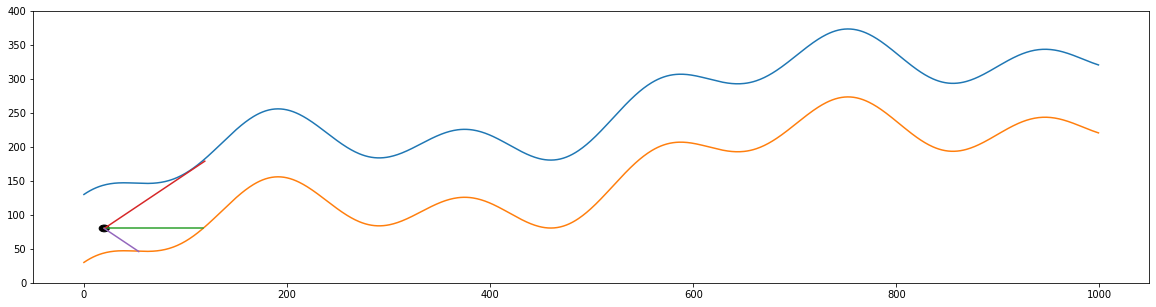

Distance from left wall =  67
Distance from right wall =  35
tavolsagra van most a felsőtől =  50.0
tavolsagra van most az alsótól =  50.0


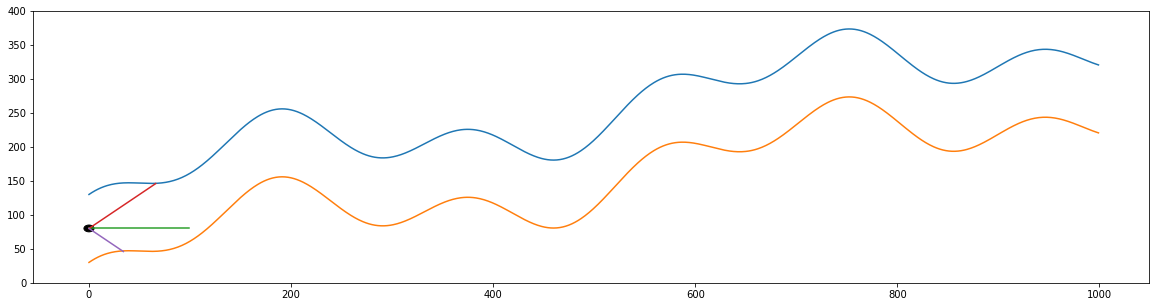

Distance from left wall =  67
Distance from right wall =  34
tavolsagra van most a felsőtől =  51.00554481025708
tavolsagra van most az alsótól =  48.99445518974293


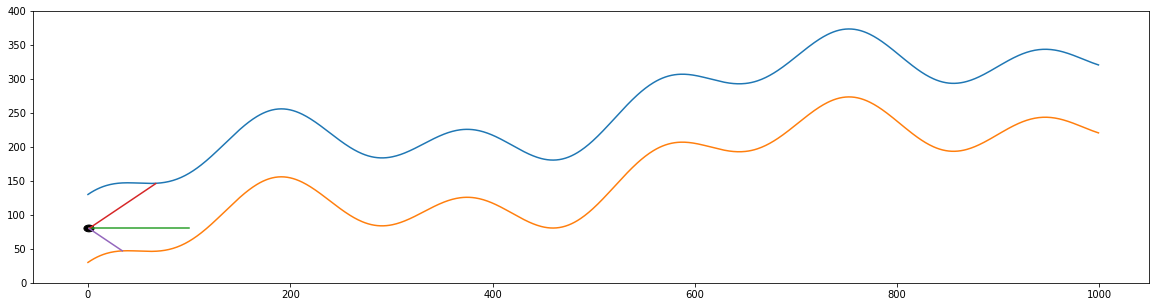

Distance from left wall =  67
Distance from right wall =  34
tavolsagra van most a felsőtől =  51.97770415959371
tavolsagra van most az alsótól =  48.022295840406294


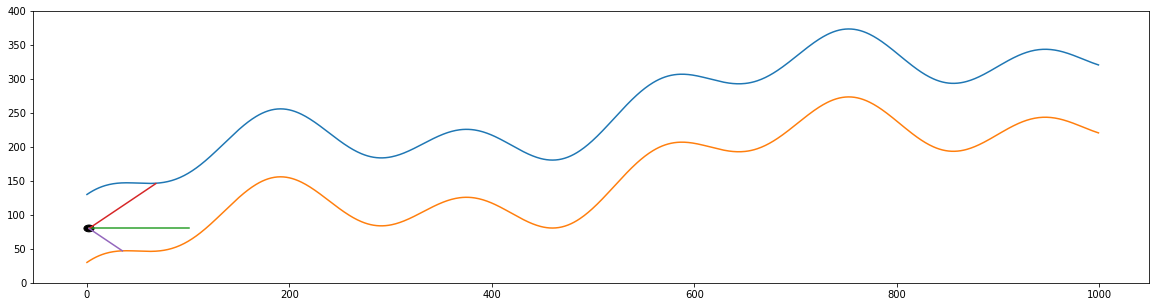

Distance from left wall =  67
Distance from right wall =  34
tavolsagra van most a felsőtől =  52.91645985235181
tavolsagra van most az alsótól =  47.08354014764819


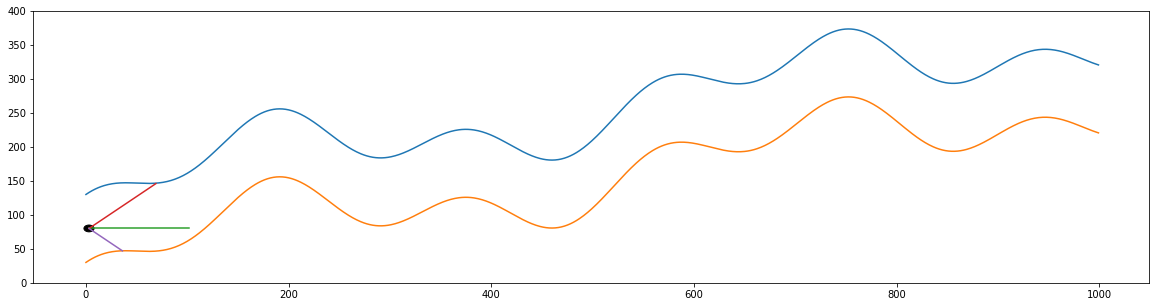

Distance from left wall =  67
Distance from right wall =  34
tavolsagra van most a felsőtől =  53.821830658044206
tavolsagra van most az alsótól =  46.17816934195579


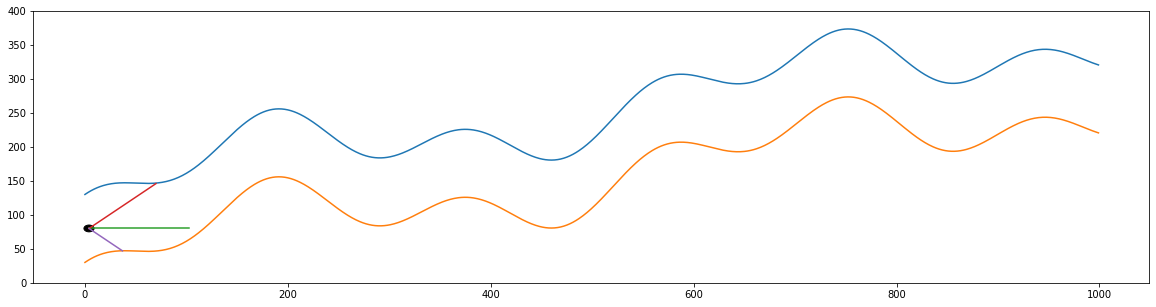

Distance from left wall =  68
Distance from right wall =  34
tavolsagra van most a felsőtől =  54.693872217239715
tavolsagra van most az alsótól =  45.30612778276029


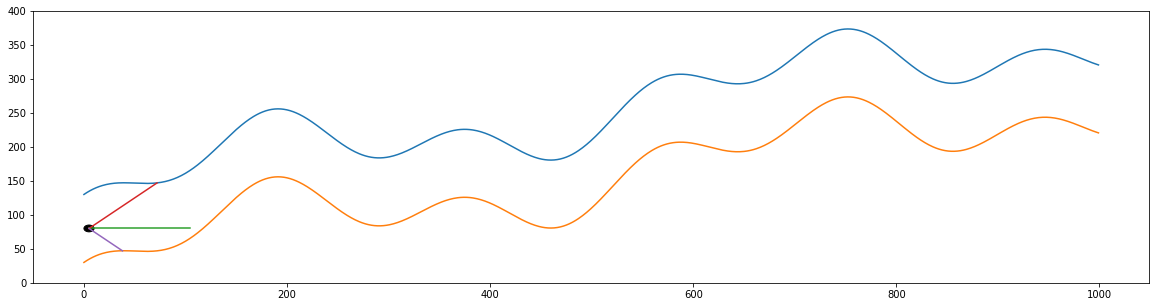

Distance from left wall =  68
Distance from right wall =  34
tavolsagra van most a felsőtől =  55.532676906509494
tavolsagra van most az alsótól =  44.46732309349049


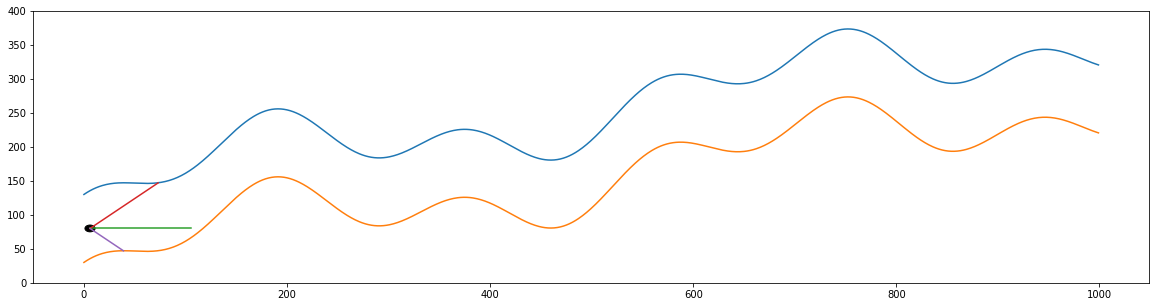

Distance from left wall =  68
Distance from right wall =  34
tavolsagra van most a felsőtől =  56.33837366259391
tavolsagra van most az alsótól =  43.661626337406084


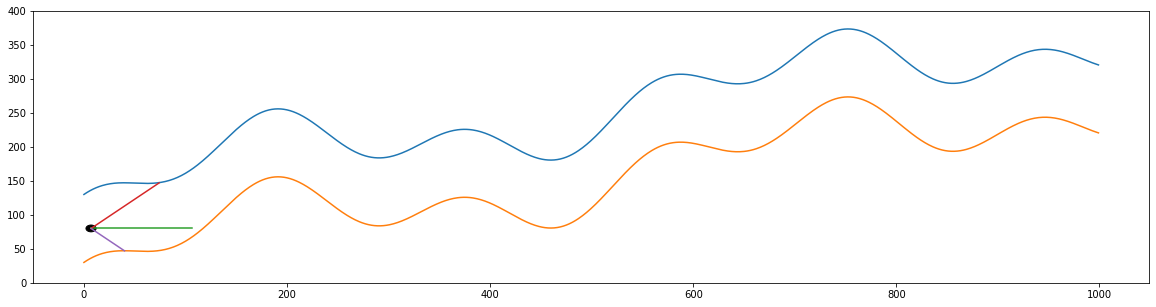

Distance from left wall =  68
Distance from right wall =  34
tavolsagra van most a felsőtől =  57.11112776599293
tavolsagra van most az alsótól =  42.88887223400705


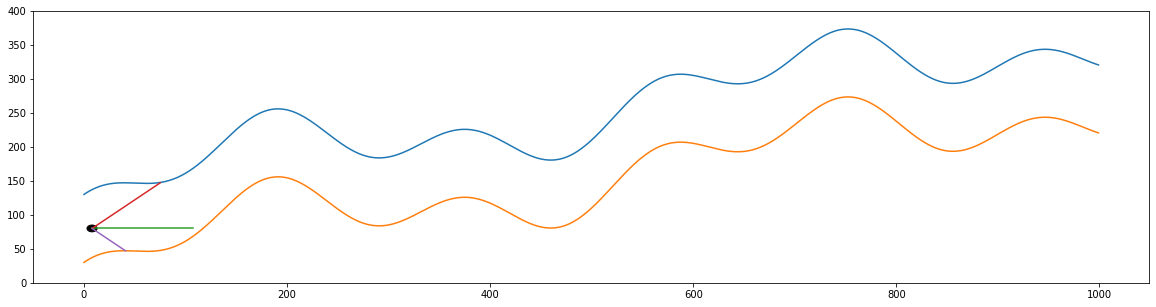

Distance from left wall =  69
Distance from right wall =  34
tavolsagra van most a felsőtől =  57.85114058422994
tavolsagra van most az alsótól =  42.14885941577007


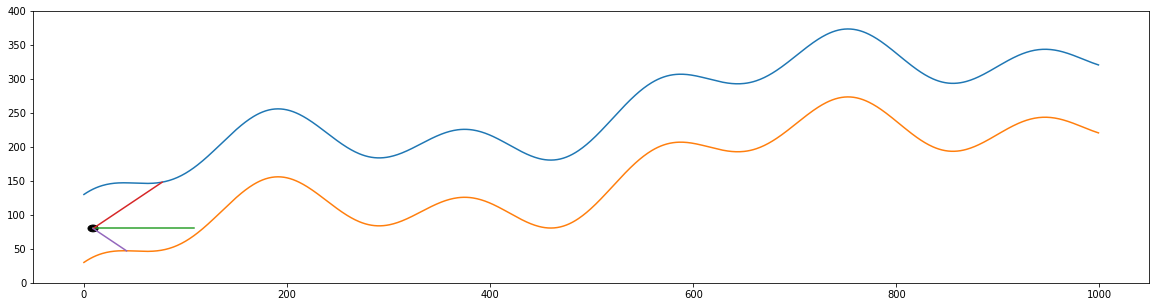

Distance from left wall =  69
Distance from right wall =  34
tavolsagra van most a felsőtől =  58.55864927508179
tavolsagra van most az alsótól =  41.44135072491821


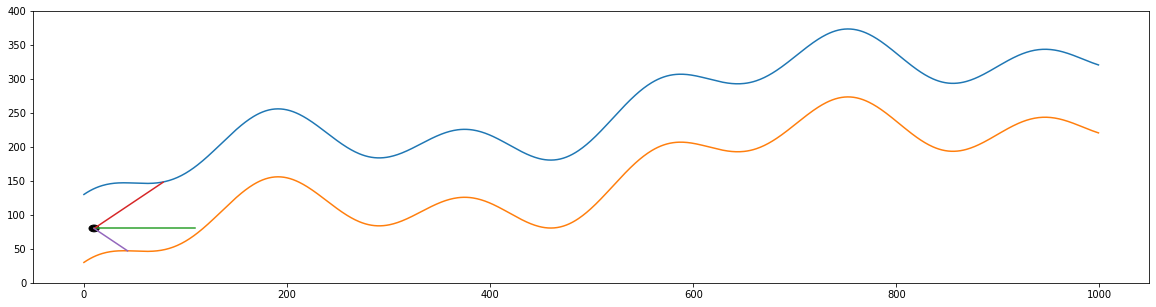

Distance from left wall =  70
Distance from right wall =  34
tavolsagra van most a felsőtől =  59.23392645011421
tavolsagra van most az alsótól =  40.76607354988579


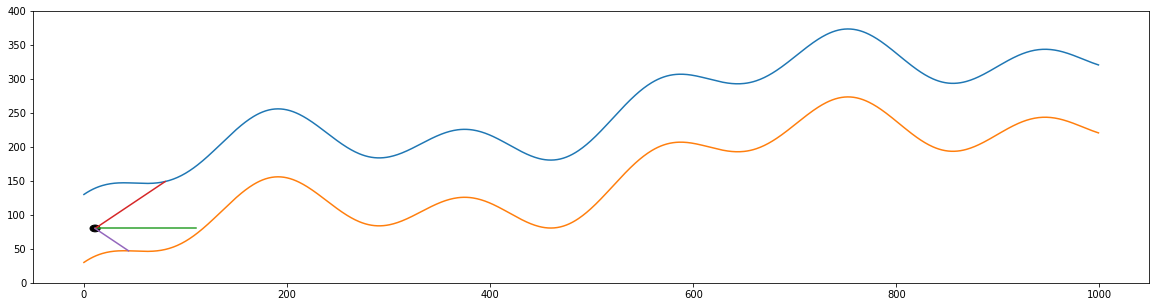

(14, 3)
(14, 1)
Distance from left wall =  70
Distance from right wall =  35
tavolsagra van most a felsőtől =  59.877279798904055
tavolsagra van most az alsótól =  40.12272020109596


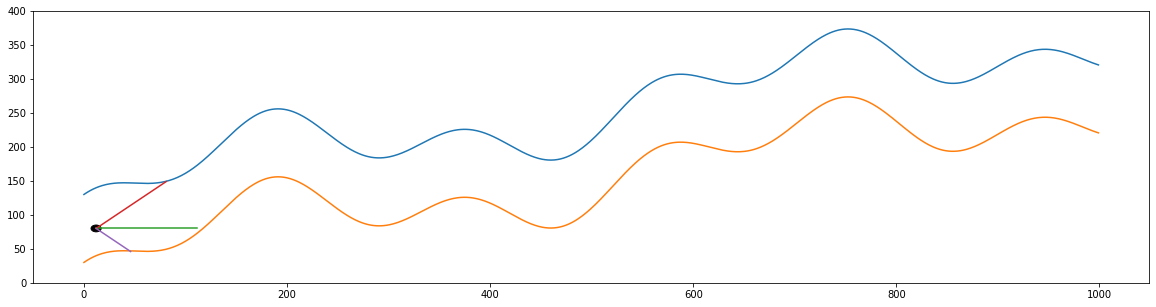

actual _X =  [[ 70 100  35]]
actual predicted =  [[7.54683098]]
Distance from left wall =  71
Distance from right wall =  35
tavolsagra van most a felsőtől =  60.48905167437499
tavolsagra van most az alsótól =  39.510948325624994


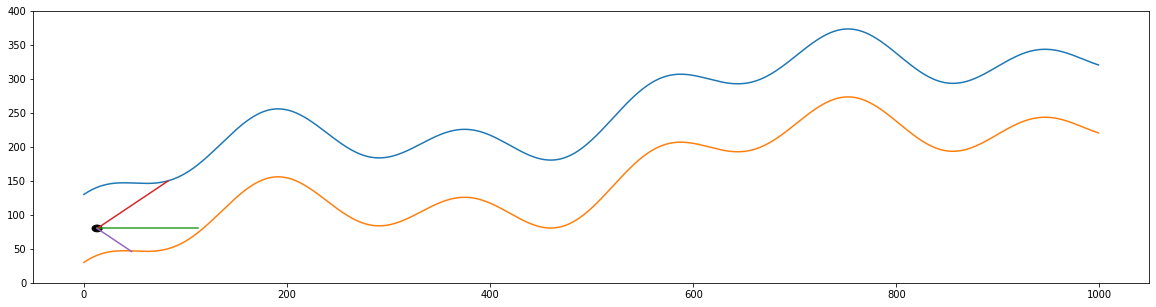

up
Distance from left wall =  70
Distance from right wall =  36
tavolsagra van most a felsőtől =  60.06961863971557
tavolsagra van most az alsótól =  39.93038136028443
self.y =  81.0
Distance from left wall =  70
Distance from right wall =  36
tavolsagra van most a felsőtől =  60.06961863971557
tavolsagra van most az alsótól =  39.93038136028443


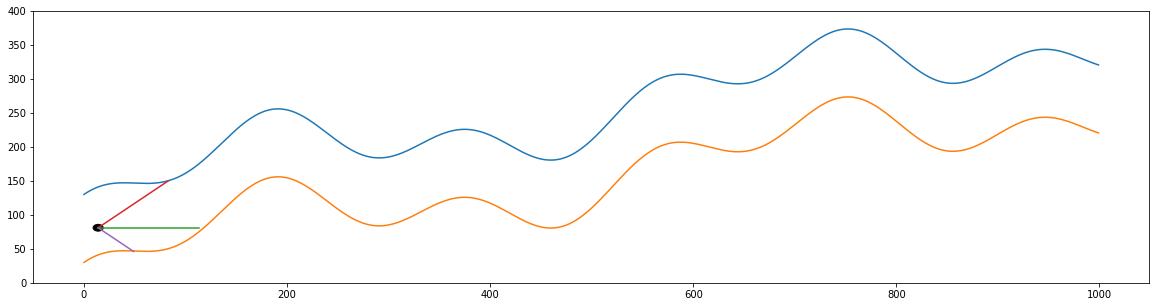

(18, 3)
(18, 1)
Distance from left wall =  71
Distance from right wall =  36
tavolsagra van most a felsőtől =  60.61939097739125
tavolsagra van most az alsótól =  39.38060902260876


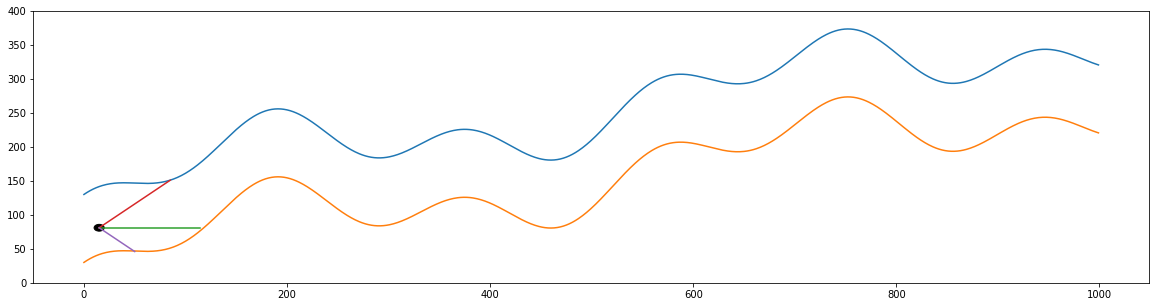

actual _X =  [[ 71 100  36]]
actual predicted =  [[11.71176182]]
Distance from left wall =  72
Distance from right wall =  36
tavolsagra van most a felsőtől =  61.13881216080489
tavolsagra van most az alsótól =  38.8611878391951


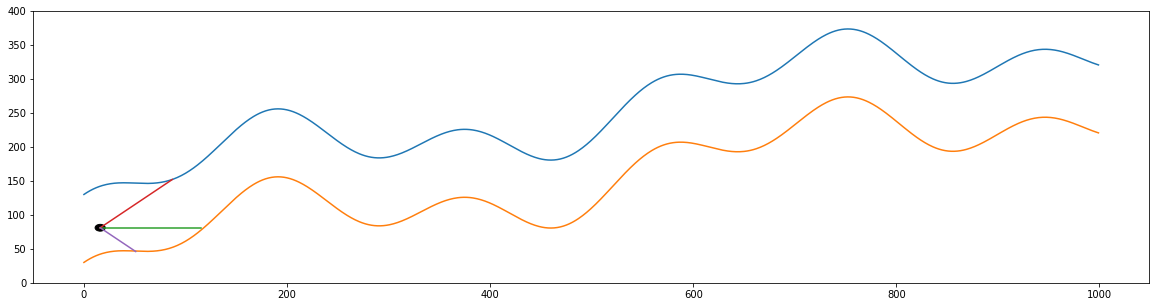

down
Distance from left wall =  76
Distance from right wall =  35
tavolsagra van most a felsőtől =  62.628358289200776
tavolsagra van most az alsótól =  37.37164171079922
self.y =  80.0
Distance from left wall =  76
Distance from right wall =  35
tavolsagra van most a felsőtől =  62.628358289200776
tavolsagra van most az alsótól =  37.37164171079922


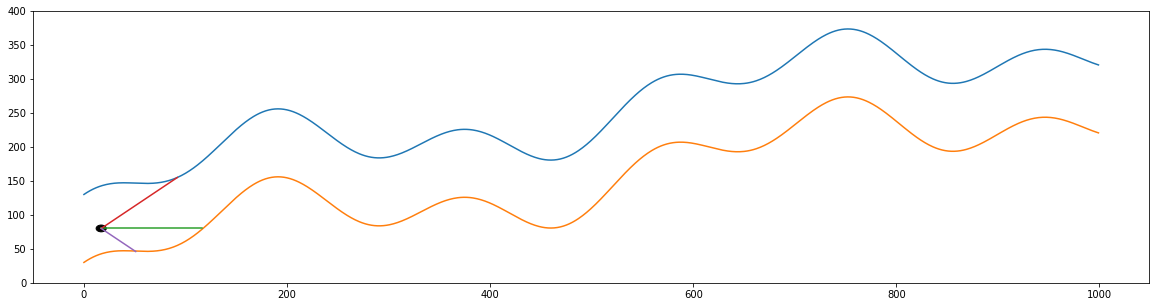

(22, 3)
(22, 1)
Distance center =  100
Distance from left wall =  78
Distance from right wall =  35
tavolsagra van most a felsőtől =  63.088537486448274
tavolsagra van most az alsótól =  36.91146251355174


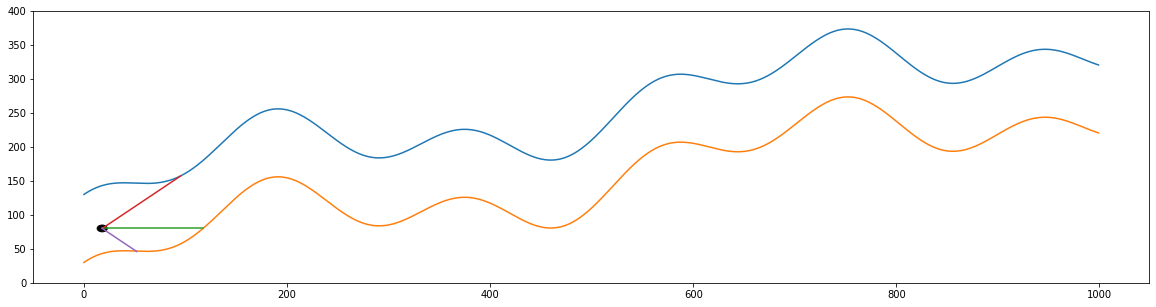

actual _X =  [[ 78 100  35]]
actual predicted =  [[16.88086474]]
Distance center =  99
Distance from left wall =  83
Distance from right wall =  35
tavolsagra van most a felsőtől =  63.519889264381845
tavolsagra van most az alsótól =  36.48011073561817


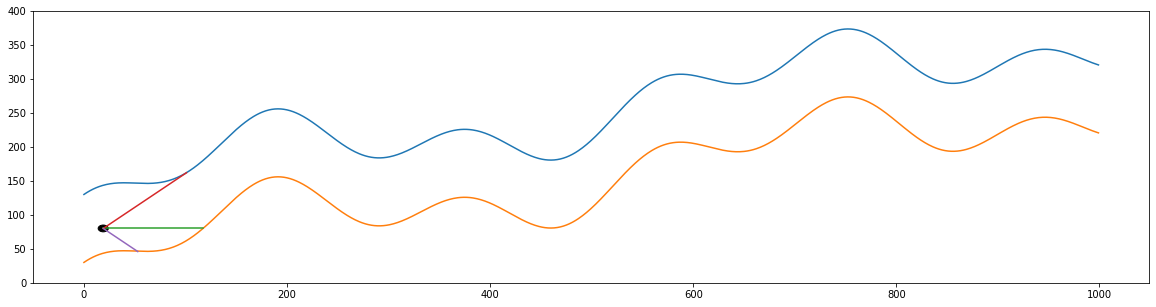

up
Distance from left wall =  82
Distance from right wall =  36
tavolsagra van most a felsőtől =  62.922983851413136
tavolsagra van most az alsótól =  37.07701614858686
self.y =  81.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1.]
(3, 4)
(3, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]]
--------------------------------------
[[-6.52047133e-17 -2.50000000e+00]]
[[-1.00000000e+00 -1.05210072e-16]]
[[3.16535562e-16 1.00000000e+00]]
-------------------------X-------------------------
[[14.  0. -5.]]
---------------Brutálisan hülye dolgot jelez előre ezért ellenőrizni kell, hogy mi a gond. Esetleg a bemeneti adatok?-----------------
[[-1440.25627608]]
--------------------------------------------------------------------------------------------------

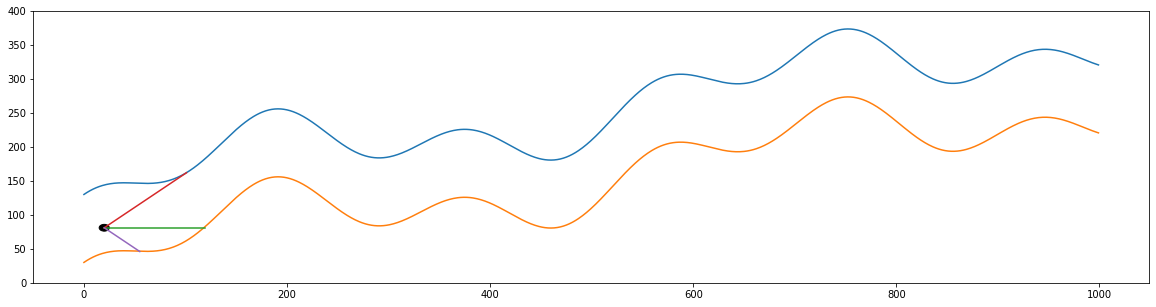

(26, 3)
(26, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1.]
(3, 4)
(3, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]]
--------------------------------------
[[-6.52047133e-17 -2.50000000e+00]]
[[-1.00000000e+00 -1.05210072e-16]]
[[3.16535562e-16 1.00000000e+00]]
-------------------------X-------------------------
[[14.  0. -5.]]
---------------Brutálisan hülye dolgot jelez előre ezért ellenőrizni kell, hogy mi a gond. Esetleg a bemeneti adatok?-----------------
[[-542.70007755]]
---------------------------------------------------------------------------------------------------------------------------------------
	---------------------
	 action =  -5
	 predicted_position =  [[-542.70007755]]
	---------------------
	 j =  -5
------------------

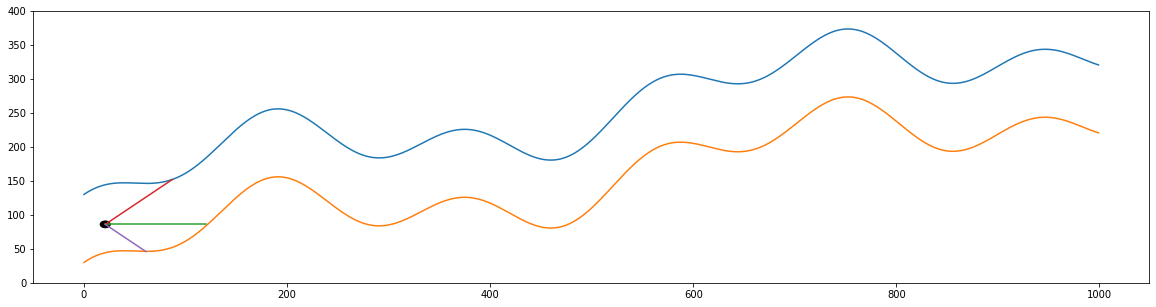

actual _X =  [[ 67 100  41]]
actual predicted =  [[13.81899313]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1.]
(3, 4)
(3, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]]
--------------------------------------
[[-6.52047133e-17 -2.50000000e+00]]
[[-1.00000000e+00 -1.05210072e-16]]
[[3.16535562e-16 1.00000000e+00]]
-------------------------X-------------------------
[[14.  0. -5.]]
---------------Brutálisan hülye dolgot jelez előre ezért ellenőrizni kell, hogy mi a gond. Esetleg a bemeneti adatok?-----------------
[[-542.70007755]]
---------------------------------------------------------------------------------------------------------------------------------------
	---------------------
	 action =  -5
	 predicted_position =  [[-542.70007755]]
	-

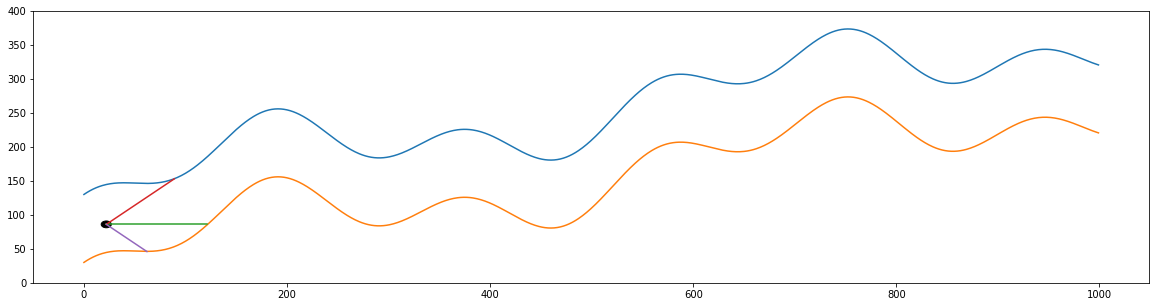

down
Distance from left wall =  73
Distance from right wall =  40
tavolsagra van most a felsőtől =  59.968872455824
tavolsagra van most az alsótól =  40.03112754417599
self.y =  85.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.]
(4, 4)
(4, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]]
--------------------------------------
[[-0.025  -2.6625]]
[[-1.00000000e+00 -1.46428422e-17]]
[[1.25146423e-16 1.00000000e+00]]
-------------------------X-------------------------
[[15.075  0.    -5.   ]]
---------------Brutálisan hülye dolgot jelez előre ezért ellenőrizni kell, hogy mi a gond. Esetleg a bemeneti adatok?-----------------
[[-542.11700217]]
------------------

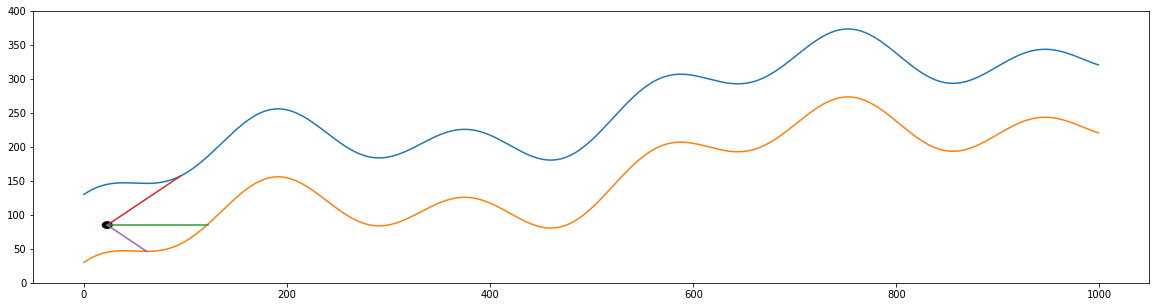

(30, 3)
(30, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.]
(4, 4)
(4, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]]
--------------------------------------
[[-0.025  -2.6625]]
[[-1.00000000e+00 -1.46428422e-17]]
[[1.25146423e-16 1.00000000e+00]]
-------------------------X-------------------------
[[15.075  0.    -5.   ]]
---------------Brutálisan hülye dolgot jelez előre ezért ellenőrizni kell, hogy mi a gond. Esetleg a bemeneti adatok?-----------------
[[-617.3627854]]
---------------------------------------------------------------------------------------------------------------------------------------
	---------------------
	 action =  -5
	 predicted_

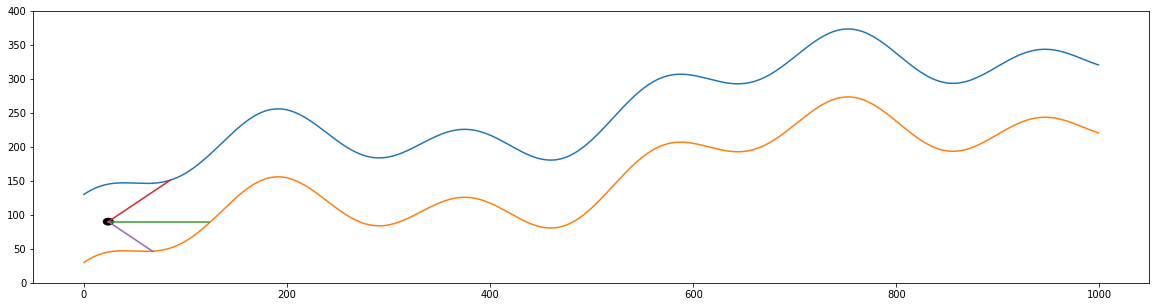

actual _X =  [[ 62 100  45]]
actual predicted =  [[6.20539537]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.]
(4, 4)
(4, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]]
--------------------------------------
[[-0.025  -2.6625]]
[[-1.00000000e+00 -1.46428422e-17]]
[[1.25146423e-16 1.00000000e+00]]
-------------------------X-------------------------
[[15.35  0.   -5.  ]]
---------------Brutálisan hülye dolgot jelez előre ezért ellenőrizni kell, hogy mi a gond. Esetleg a bemeneti adatok?-----------------
[[-617.1902293]]
---------------------------------------------------------------------------------------------------------------------------------------
	----

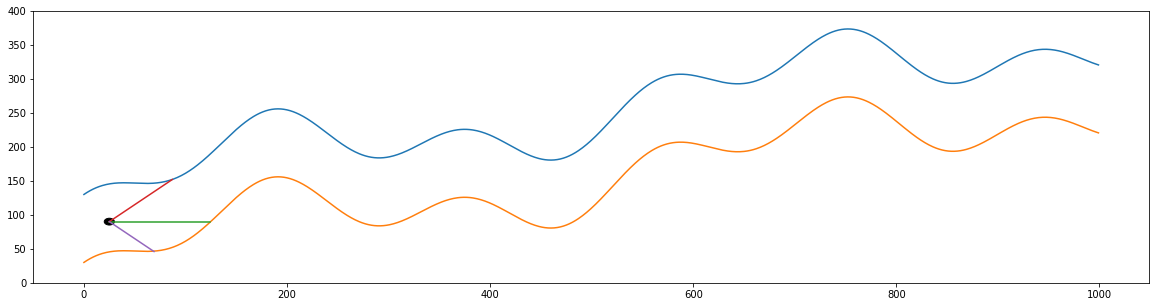

up
Distance center =  100
Distance from left wall =  62
Distance from right wall =  46
tavolsagra van most a felsőtől =  54.78376882613719
tavolsagra van most az alsótól =  45.21623117386281
self.y =  91.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1.]
(5, 4)
(5, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]
 [ 1. -1.  0.  1.]]
--------------------------------------
[[-0.00949367 -2.73892405]]
[[-1.0000000e+00  1.3717258e-17]]
[[-6.27886329e-19  1.00000000e+00]]
-------------------------X-------------------------
[[15.53164557  0.         -5.        ]]
---------------Brutálisan hülye dolg

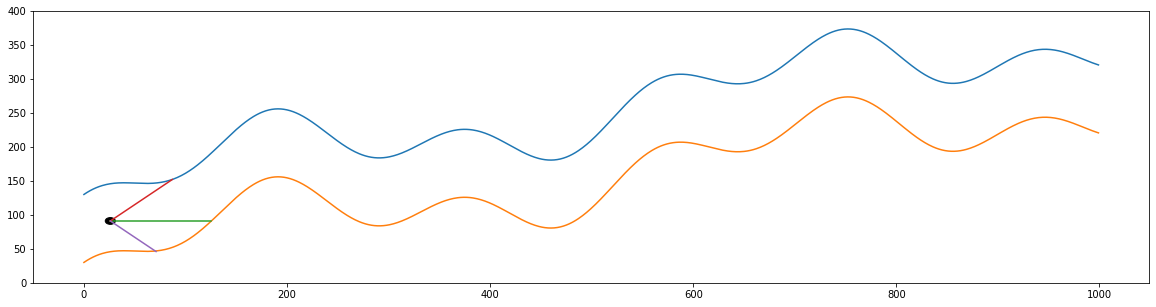

(34, 3)
(34, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1.]
(5, 4)
(5, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]
 [ 1. -1.  0.  1.]]
--------------------------------------
[[-0.00949367 -2.73892405]]
[[-1.0000000e+00  1.3717258e-17]]
[[-6.27886329e-19  1.00000000e+00]]
-------------------------X-------------------------
[[15.53164557  0.         -5.        ]]
---------------Brutálisan hülye dolgot jelez előre ezért ellenőrizni kell, hogy mi a gond. Esetleg a bemeneti adatok?-----------------
[[-651.36239312]]
-------------------------------------------------------------------------

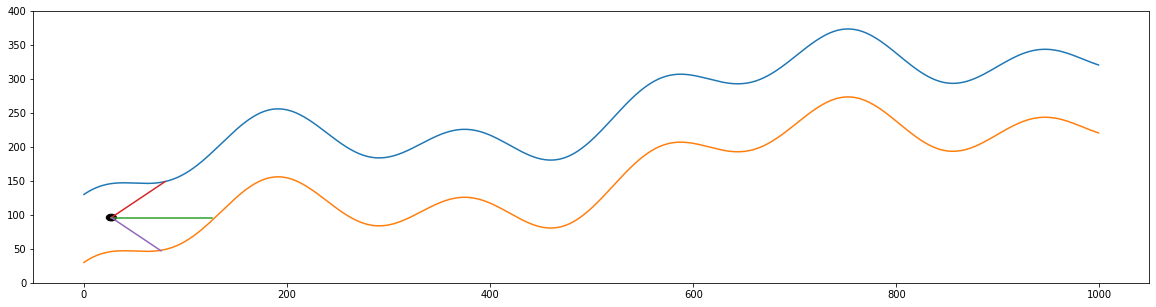

actual _X =  [[ 54 100  50]]
actual predicted =  [[1.22728614]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1.]
(5, 4)
(5, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]
 [ 1. -1.  0.  1.]]
--------------------------------------
[[-0.00949367 -2.73892405]]
[[-1.0000000e+00  1.3717258e-17]]
[[-6.27886329e-19  1.00000000e+00]]
-------------------------X-------------------------
[[15.60759494  0.         -5.        ]]
---------------Brutálisan hülye dolgot jelez előre ezért ellenőrizni kell, hogy mi a gond. Esetleg a bemeneti adatok?-----------------
[[-651.31284486]]
-------------------------

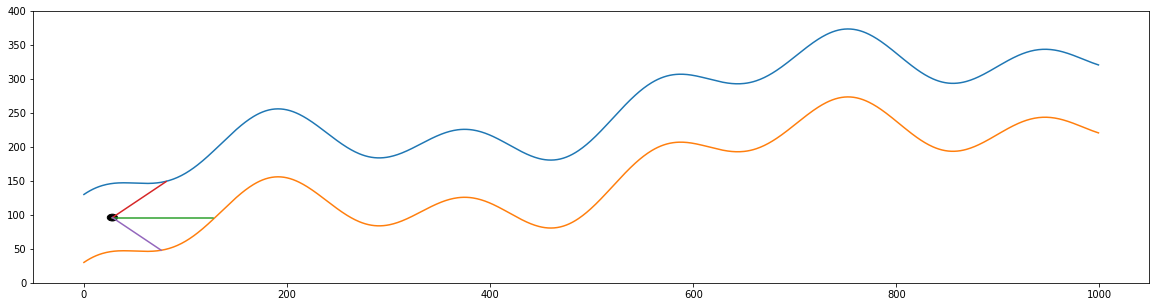

down
Distance center =  100
Distance from left wall =  57
Distance from right wall =  48
tavolsagra van most a felsőtől =  51.387590664964705
tavolsagra van most az alsótól =  48.61240933503528
self.y =  95.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.]
(6, 4)
(6, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]
 [ 1. -1.  0.  1.]
 [-1.  3.  0. -1.]]
--------------------------------------
[[ 0.03671329 -2.64073427]]
[[-1.00000000e+00 -5.98516317e-17]]
[[5.23291468e-18 1.00000000e+00]]
-------------------------X----------

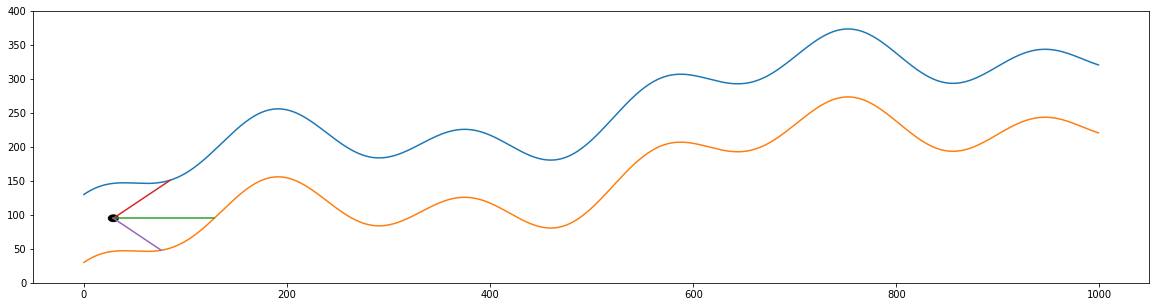

(38, 3)
(38, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.]
(6, 4)
(6, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]
 [ 1. -1.  0.  1.]
 [-1.  3.  0. -1.]]
--------------------------------------
[[ 0.03671329 -2.64073427]]
[[-1.00000000e+00 -5.98516317e-17]]
[[5.23291468e-18 1.00000000e+00]]
-------------------------X-------------------------
[[14.28146853  0.         -5.        ]]
---------------Brutálisan hülye dolgot jelez előre ezért ellenőrizni kell, hogy mi a gond. Esetleg a bemeneti adatok?-----------------
[[

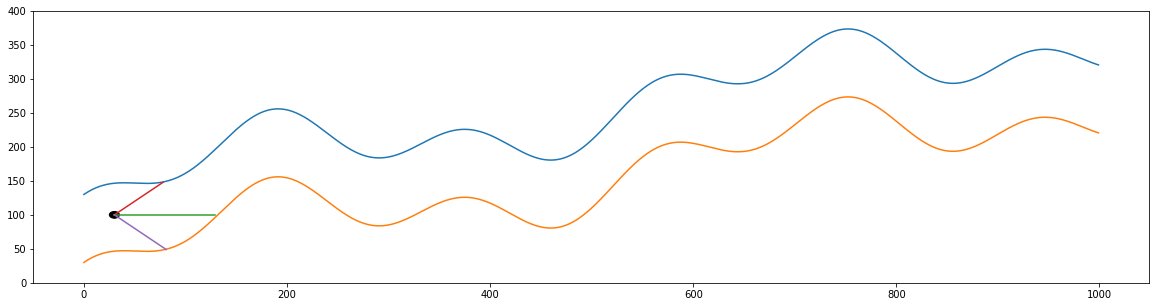

actual _X =  [[ 49 100  52]]
actual predicted =  [[-2.39839364]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.]
(6, 4)
(6, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]
 [ 1. -1.  0.  1.]
 [-1.  3.  0. -1.]]
--------------------------------------
[[ 0.03671329 -2.64073427]]
[[-1.00000000e+00 -5.98516317e-17]]
[[5.23291468e-18 1.00000000e+00]]
-------------------------X-------------------------
[[13.98776224  0.         -5.        ]]
---------------Brutálisan hülye dolgot jelez előre ezért ellenőrizni kell, hogy mi a gon

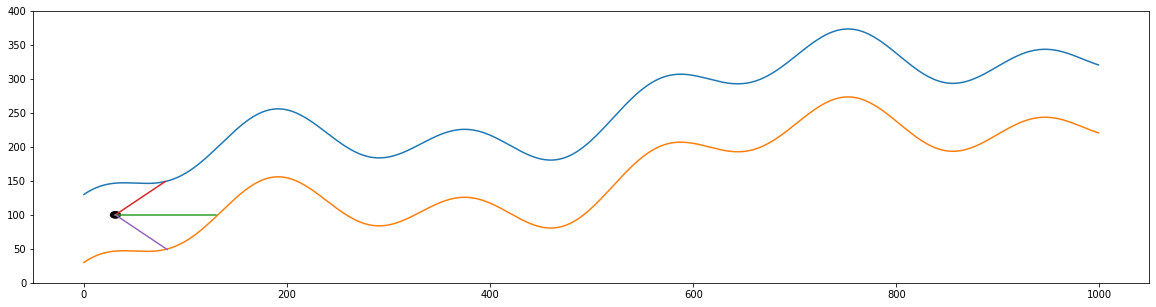

up
Distance from left wall =  49
Distance from right wall =  52
tavolsagra van most a felsőtől =  45.80221246822816
tavolsagra van most az alsótól =  54.19778753177184
self.y =  101.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1.]
(7, 4)
(7, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]
 [ 1. -1.  0.  1.]
 [-1.  3.  0. -1.]
 [ 1. -1.  0.  0.]]
--------------------------------------
[[ 0.01853282 -2.51930502]]
[[-1.00000000e+00  3.04139231e-17]]
[[-0.0

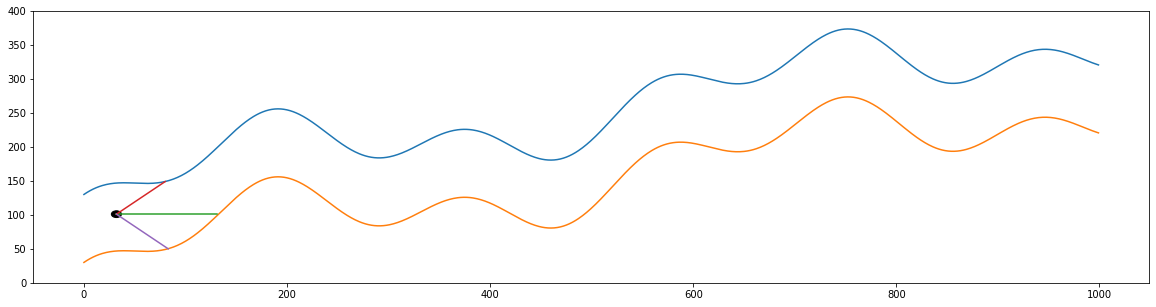

(42, 3)
(42, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1.]
(7, 4)
(7, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]
 [ 1. -1.  0.  1.]
 [-1.  3.  0. -1.]
 [ 1. -1.  0.  0.]]
--------------------------------------
[[ 0.01853282 -2.51930502]]
[[-1.00000000e+00  3.04139231e-17]]
[[-0.03501281  0.8706234 ]]
-------------------------X-------------------------
[[13.78687259  0.         -4.83262169]]
---------------Brutálisan hülye dolgot jelez előre ezé

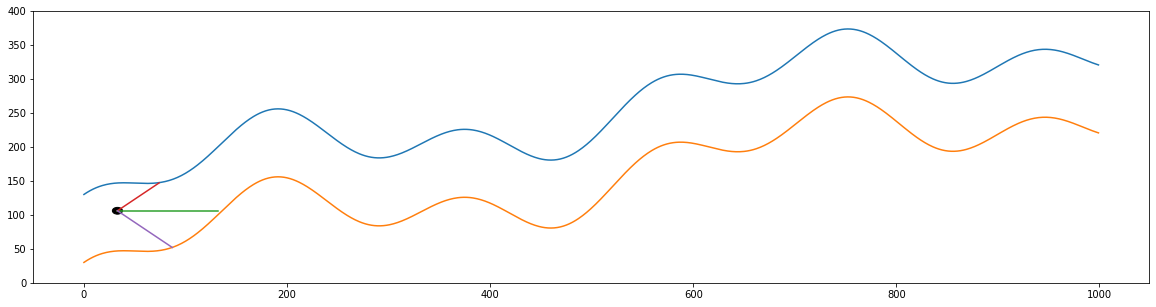

actual _X =  [[ 42 100  55]]
actual predicted =  [[-7.43667657]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1.]
(7, 4)
(7, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]
 [ 1. -1.  0.  1.]
 [-1.  3.  0. -1.]
 [ 1. -1.  0.  0.]]
--------------------------------------
[[ 0.01853282 -2.51930502]]
[[-1.00000000e+00  3.04139231e-17]]
[[-0.03501281  0.8706234 ]]
-------------------------X-------------------------
[[13.65714286  0.         -4.93766012]]
-----

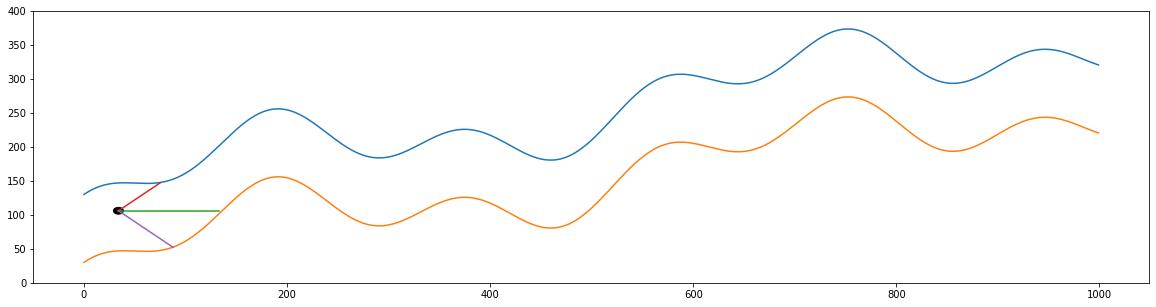

down
Distance from left wall =  44
Distance from right wall =  54
tavolsagra van most a felsőtől =  42.05122994730772
tavolsagra van most az alsótól =  57.94877005269228
self.y =  105.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.]
(8, 4)
(8, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]
 [ 1. -1.  0.  1.]
 [-1.  3.  0. -1.]
 [ 1. -1.  0.  0.]
 [-1.  2.  0. -1.]]
------------------

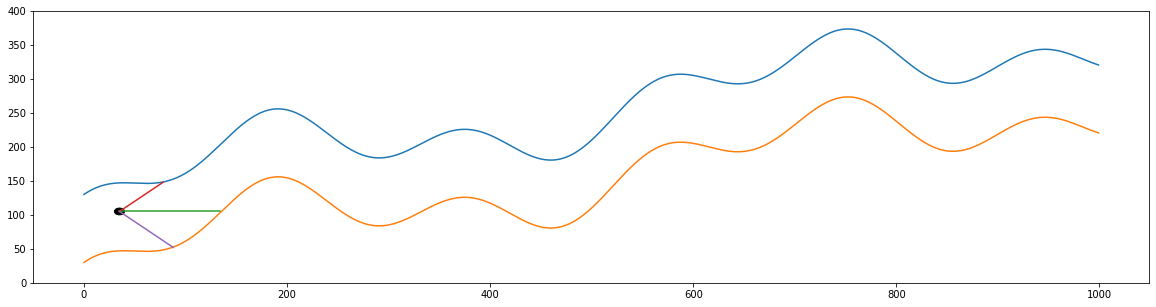

(46, 3)
(46, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.]
(8, 4)
(8, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]
 [ 1. -1.  0.  1.]
 [-1.  3.  0. -1.]
 [ 1. -1.  0.  0.]
 [-1.  2.  0. -1.]]
--------------------------------------
[[ 0.04207758 -2.41305062]]
[[-1.00000000e+00 -5.60743012e-17]]
[[-0.02443385  0.83224076]]
-------------------------X-------------------------
[[12.

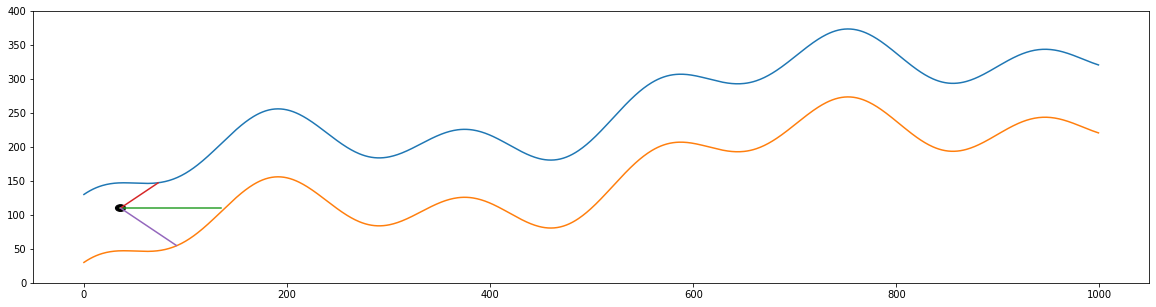

actual _X =  [[ 38 100  56]]
actual predicted =  [[-10.919784]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.]
(8, 4)
(8, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]
 [ 1. -1.  0.  1.]
 [-1.  3.  0. -1.]
 [ 1. -1.  0.  0.]
 [-1.  2.  0. -1.]]
--------------------------------------
[[ 0.04207758 -2.41305062]]
[[-1.00000000e+00 -5.60743012e-17]]
[[-0.02443385  0.83224076]]
---------

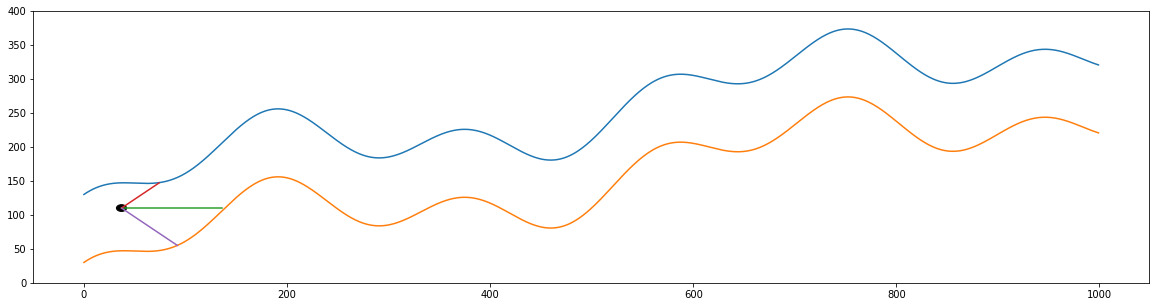

up
Distance from left wall =  37
Distance from right wall =  56
tavolsagra van most a felsőtől =  36.15970743054791
tavolsagra van most az alsótól =  63.84029256945208
self.y =  111.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1.]
(9, 4)
(9, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array([111.,  37., 100.,  56.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]
 [ 1. -1.  0.  1.]
 [-1.  3

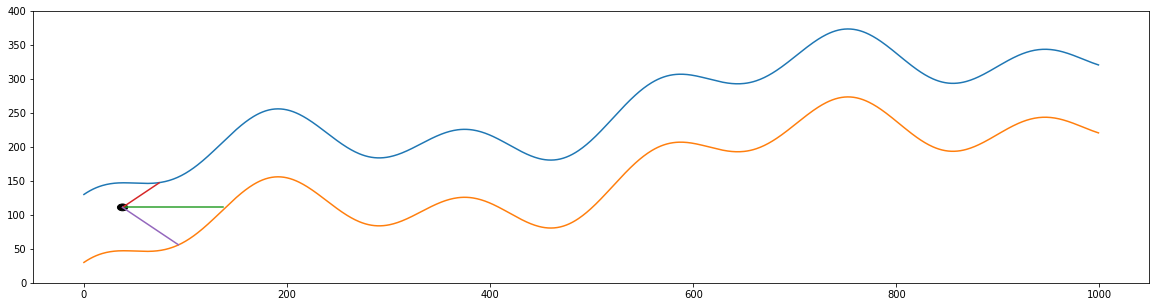

(50, 3)
(50, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1.]
(9, 4)
(9, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array([111.,  37., 100.,  56.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]
 [ 1. -1.  0.  1.]
 [-1.  3.  0. -1.]
 [ 1. -1.  0.  0.]
 [-1.  2.  0. -1.]
 [ 1. -1.  0.  0.]]
--------------------------------------
[[ 0.02663707 -2.27663707]]
[[-1.00000000e+00  5.42812698e-1

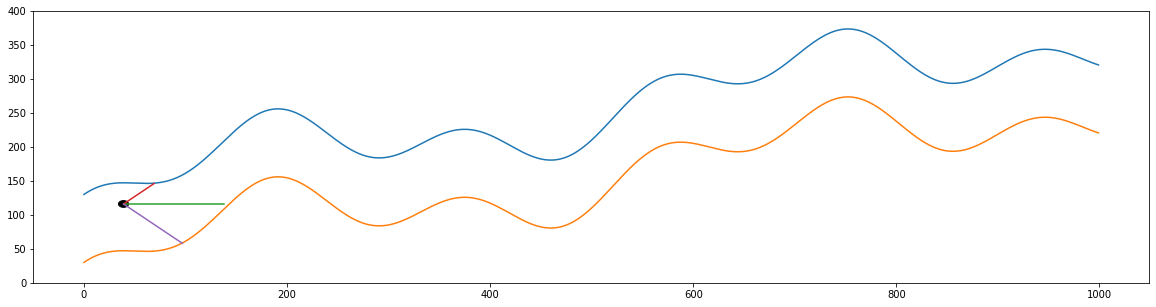

actual _X =  [[ 31 100  59]]
actual predicted =  [[-16.40406622]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1.]
(9, 4)
(9, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array([111.,  37., 100.,  56.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]
 [ 1. -1.  0.  1.]
 [-1.  3.  0. -1.]
 [ 1. -1.  0.  0.]
 [-1.  2.  0. -1.]
 [ 1. -1.  0.  0.]]
--------------------------------------
[[ 0.02663

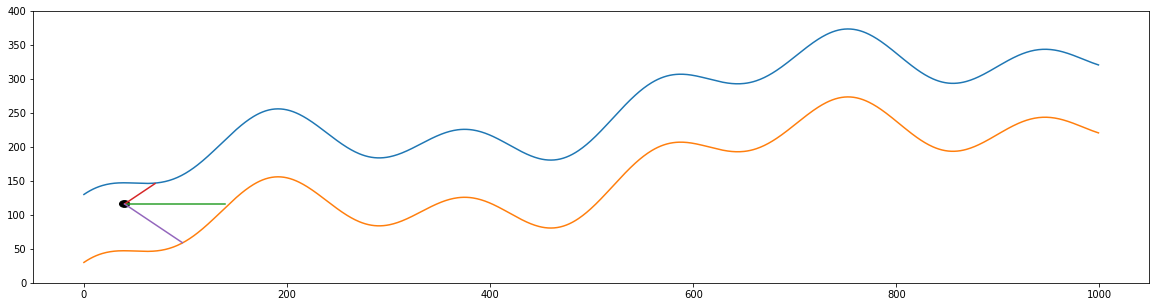

down
Distance from left wall =  33
Distance from right wall =  57
tavolsagra van most a felsőtől =  32.153910785599834
tavolsagra van most az alsótól =  67.84608921440017
self.y =  115.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(10, 4)
(10, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array([111.,  37., 100.,  56.]), array([115.,  33., 100.,  57.])]
[[ 1. -1.  0.  1.]
 [-1.  4.

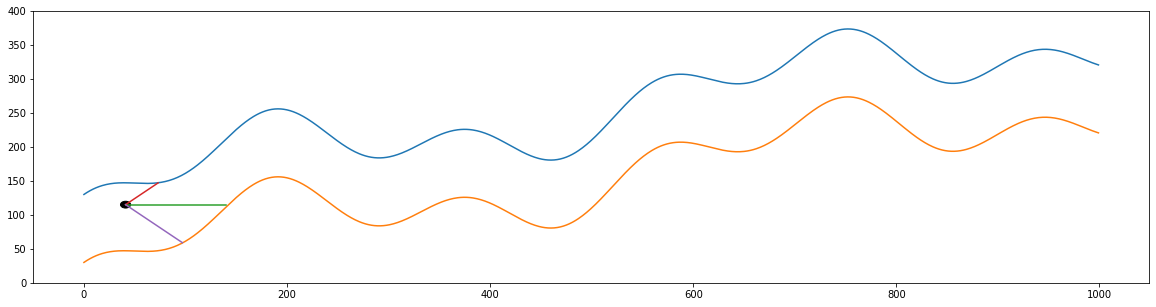

(54, 3)
(54, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(10, 4)
(10, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array([111.,  37., 100.,  56.]), array([115.,  33., 100.,  57.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]
 [ 1. -1.  0.  1.]
 [-1.  3.  0. -1.]
 [ 1. -1.  0.  0.]
 [-1.  2.  0. -1.]
 [ 1. -1.  0.  0.]
 [-1.  2.  0. -1.]]
--------

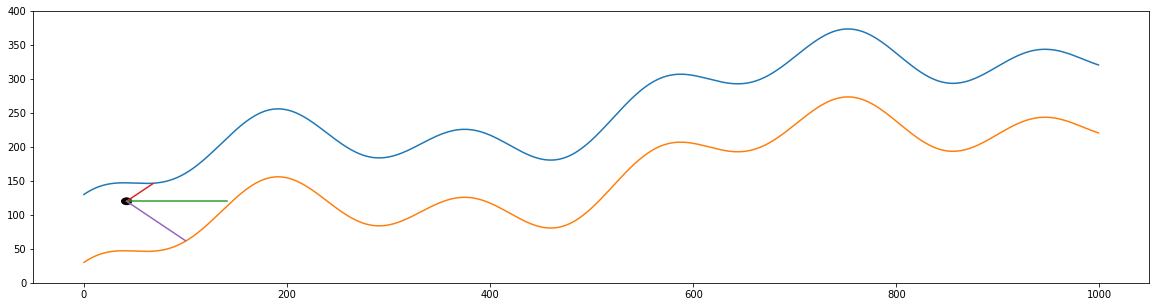

actual _X =  [[ 27 100  59]]
actual predicted =  [[-20.59103344]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(10, 4)
(10, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array([111.,  37., 100.,  56.]), array([115.,  33., 100.,  57.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]
 [ 1. -1.  0.  1.]
 [-1.  3.  0. -1.]
 [ 1. -1.  0.  0.]
 [-1.  2.  0. -1

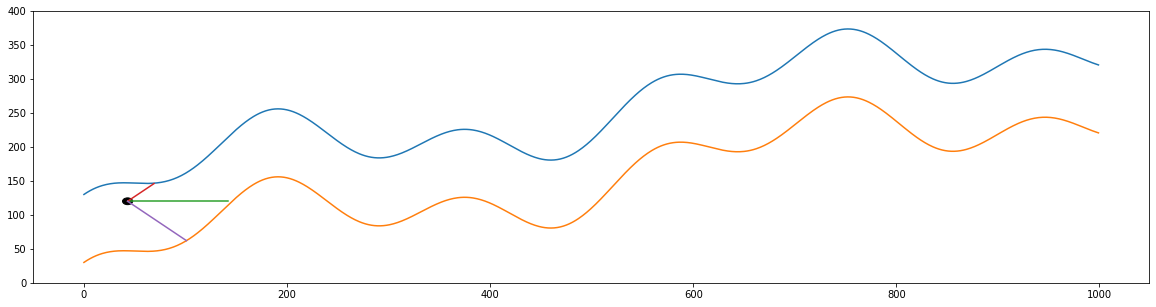

up
Distance from left wall =  26
Distance from right wall =  59
tavolsagra van most a felsőtől =  26.061028548537422
tavolsagra van most az alsótól =  73.93897145146258
self.y =  121.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(11, 4)
(11, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array([111.,  37., 100.,  56.]), array([115.,  33., 100.,  

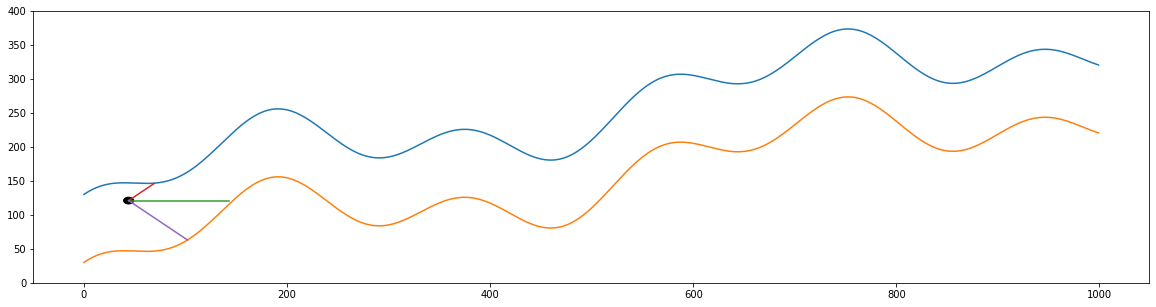

(58, 3)
(58, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(11, 4)
(11, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array([111.,  37., 100.,  56.]), array([115.,  33., 100.,  57.]), array([121.,  26., 100.,  59.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]
 [ 1. -1.  0.  1.]
 [-1.  3.  0. -1.]
 [ 1. -1.  0.  

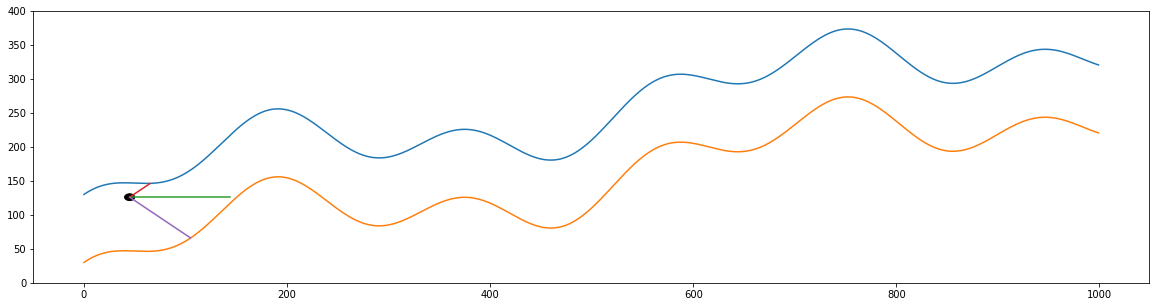

actual _X =  [[ 21 100  61]]
actual predicted =  [[-25.96862133]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(11, 4)
(11, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array([111.,  37., 100.,  56.]), array([115.,  33., 100.,  57.]), array([121.,  26., 100.,  59.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [-1.  5.  0. -1.]
 [ 

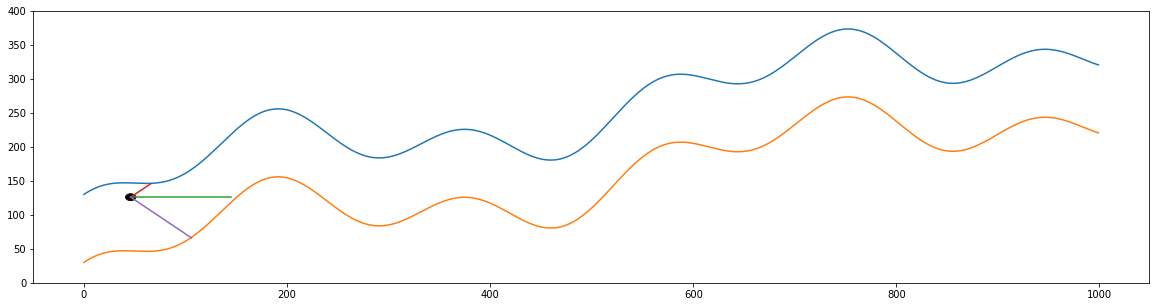

down
Distance from left wall =  22
Distance from right wall =  60
tavolsagra van most a felsőtől =  21.908884063287417
tavolsagra van most az alsótól =  78.09111593671258
self.y =  125.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(12, 4)
(12, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array([111.,  37., 1

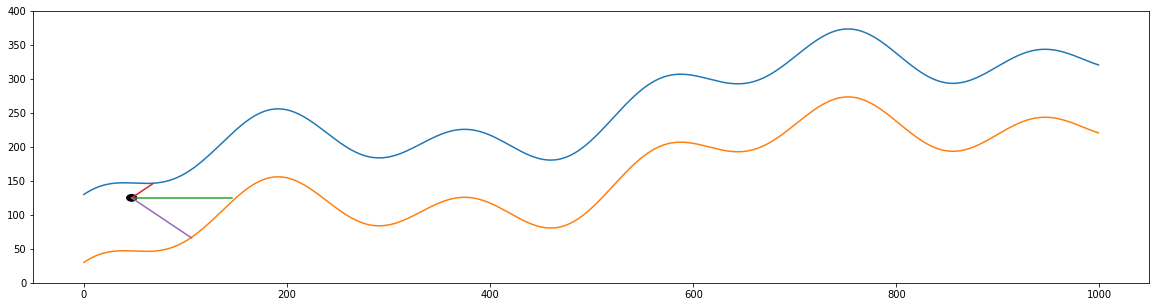

(62, 3)
(62, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(12, 4)
(12, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array([111.,  37., 100.,  56.]), array([115.,  33., 100.,  57.]), array([121.,  26., 100.,  59.]), array([125.,  22., 100.,  60.])]
[[ 1. -1.  0.  1.]
 [-1.  4.  0. -1.]
 [ 1. -1.  1.  1.]
 [

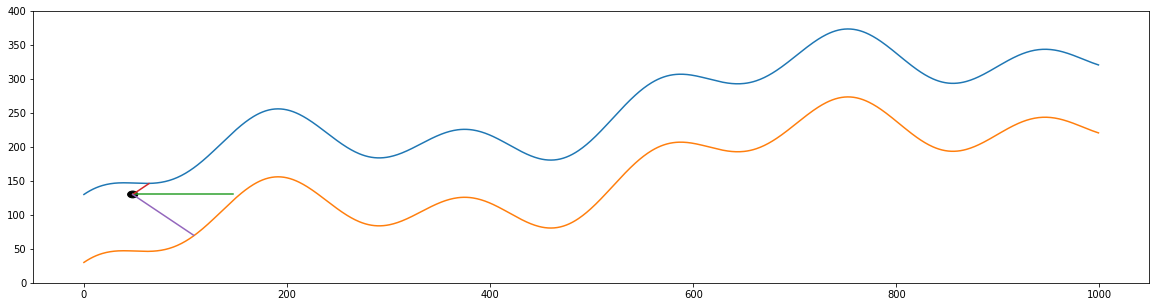

actual _X =  [[ 17 100  61]]
actual predicted =  [[-30.56563543]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(12, 4)
(12, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array([111.,  37., 100.,  56.]), array([115.,  33., 100.,  57.]), array([121.,  26., 100.,  59.]), array([125.,  22., 100.,  60.])]
[[ 1. -1.

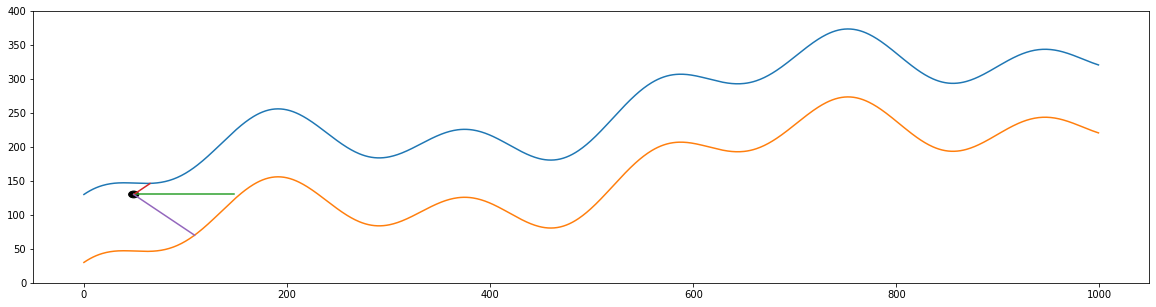

up
Distance from left wall =  16
Distance from right wall =  61
tavolsagra van most a felsőtől =  15.72564152448382
tavolsagra van most az alsótól =  84.2743584755162
self.y =  131.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(13, 4)
(13, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 1

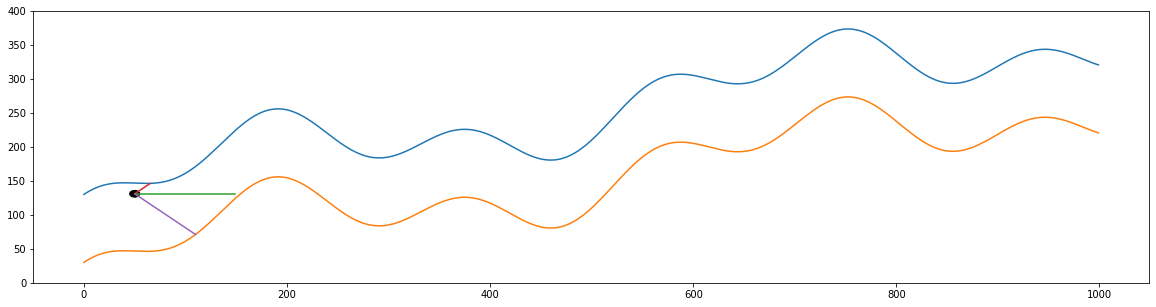

(66, 3)
(66, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(13, 4)
(13, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array([111.,  37., 100.,  56.]), array([115.,  33., 100.,  57.]), array([121.,  26., 100.,  59.]), array([125.,  22., 100.,  60.]), array([131.,  16., 100

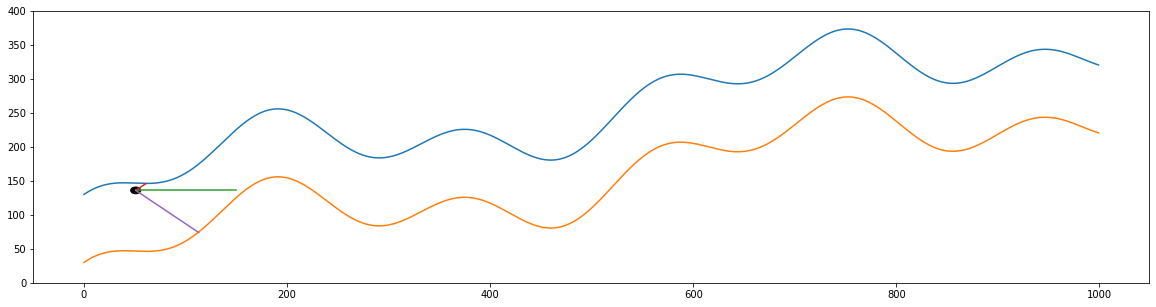

actual _X =  [[ 11 100  63]]
actual predicted =  [[-36.29780708]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(13, 4)
(13, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array([111.,  37., 100.,  56.]), array([115.,  33., 100.,  57.]), array([121.,  26., 100.,  59.]), array

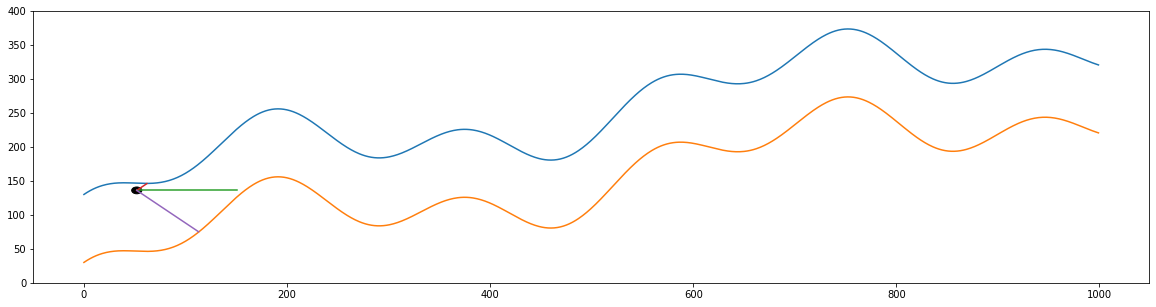

down
Distance from left wall =  12
Distance from right wall =  61
tavolsagra van most a felsőtől =  11.539508877502897
tavolsagra van most az alsótól =  88.46049112249712
self.y =  135.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(14, 4)
(14, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,

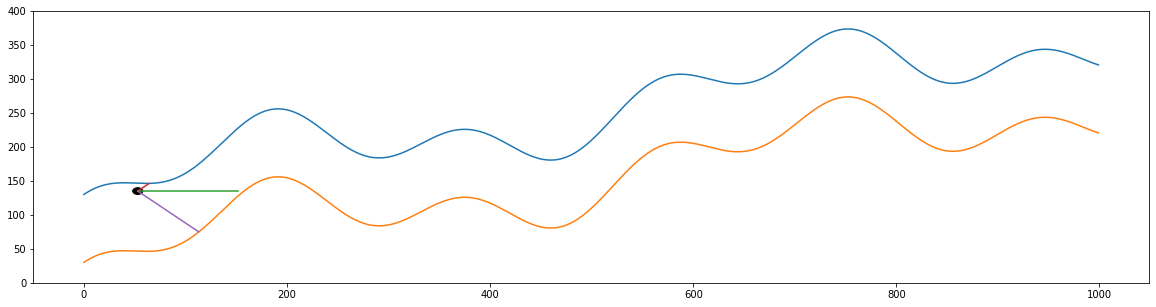

(70, 3)
(70, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(14, 4)
(14, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array([111.,  37., 100.,  56.]), array([115.,  33., 100.,  57.]), array([121.,  26., 100.,  59.]), array([125.,  22.,

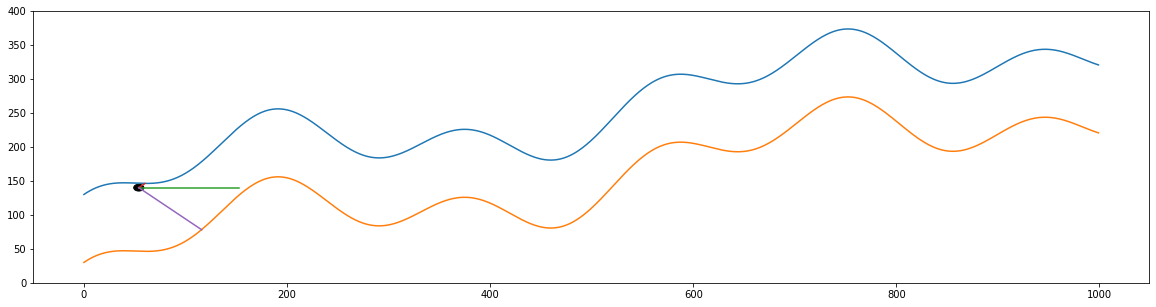

actual _X =  [[  7 100  63]]
actual predicted =  [[-41.04078095]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(14, 4)
(14, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array([111.,  37., 100.,  56.]), array([115.,  33., 100.,  57.]), a

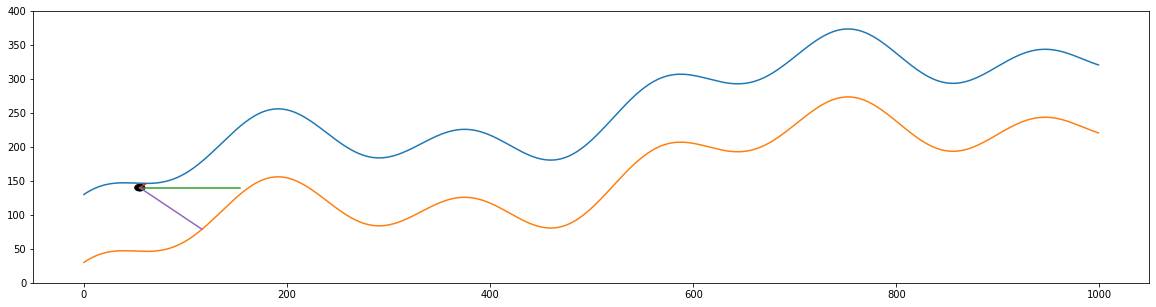

up
Distance from left wall =  6
Distance from right wall =  62
tavolsagra van most a felsőtől =  5.378440560550189
tavolsagra van most az alsótól =  94.62155943944981
self.y =  141.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(15, 4)
(15, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,

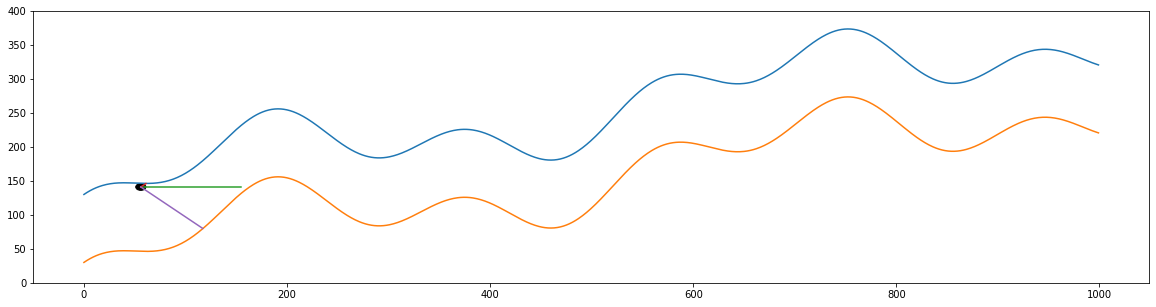

(74, 3)
(74, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(15, 4)
(15, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array([111.,  37., 100.,  56.]), array([115.,  33., 100.,  57.]), array([121.,  

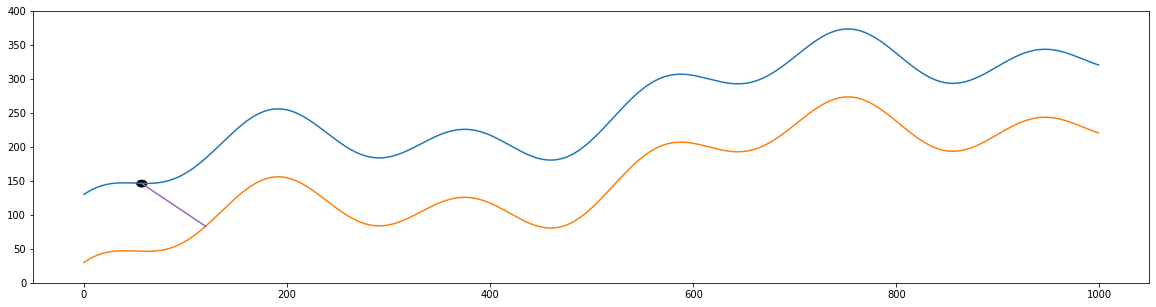

actual _X =  [[ 1  1 64]]
actual predicted =  [[-1176.84681572]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(15, 4)
(15, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array([111.,  37., 100.,  56.])

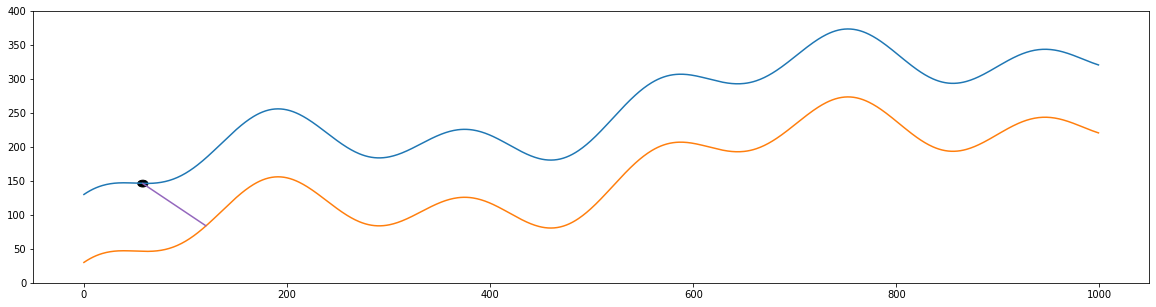

down
Distance from left wall =  2
Distance from right wall =  62
tavolsagra van most a felsőtől =  1.269843074942628
tavolsagra van most az alsótól =  98.73015692505737
self.y =  145.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(16, 4)
(16, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array(

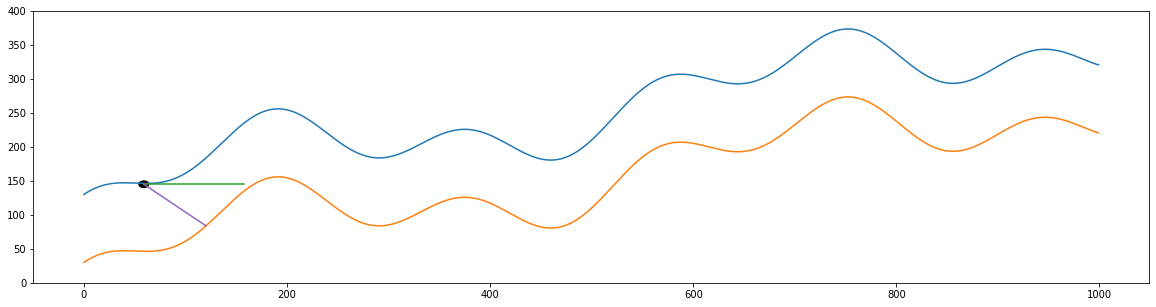

(78, 3)
(78, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(16, 4)
(16, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array([111.,  37., 100.,  56.]), array([115

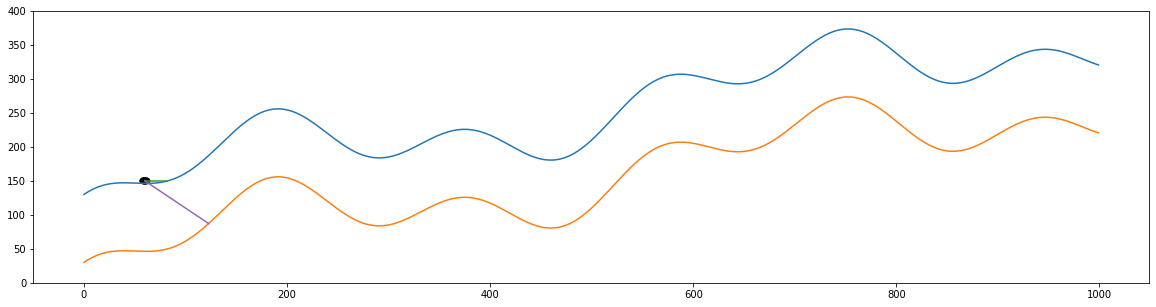

actual _X =  [[ 1 23 64]]
actual predicted =  [[-48.68833189]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(16, 4)
(16, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.

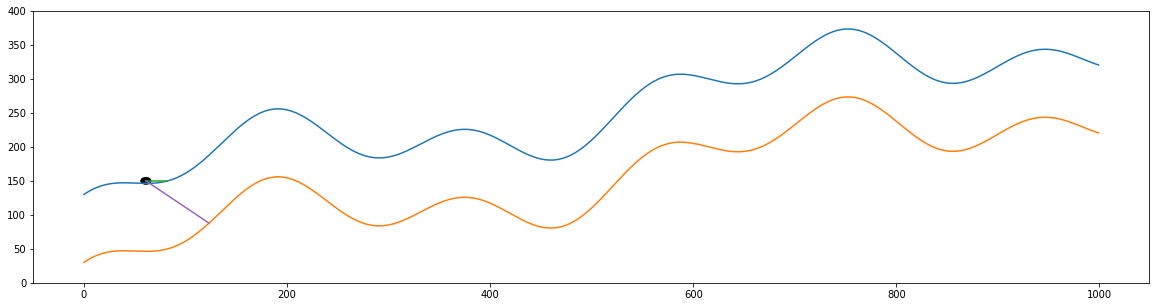

up
Distance center =  23
Distance from left wall =  1
Distance from right wall =  63
tavolsagra van most a felsőtől =  4.75971365885141
tavolsagra van most az alsótól =  104.75971365885142
self.y =  151.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(17, 4)
(17, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  8

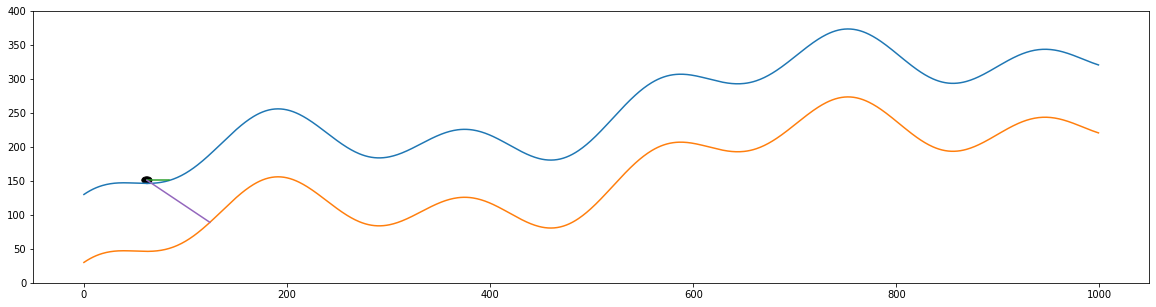

(82, 3)
(82, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(17, 4)
(17, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), array([105.,  44., 100.,  54.]), array(

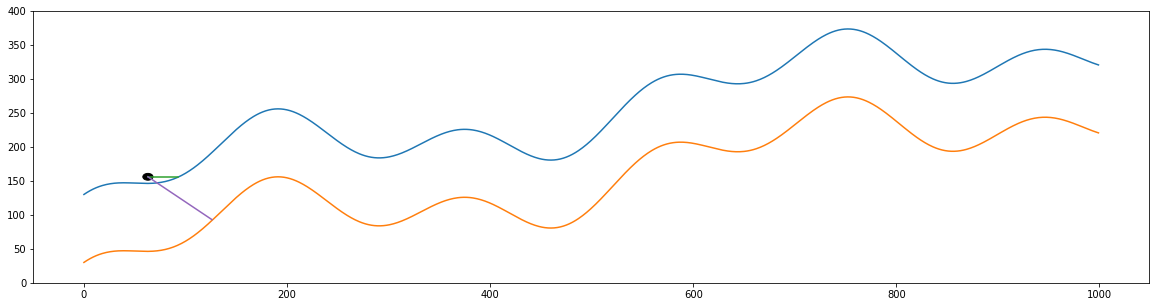

actual _X =  [[ 1 31 64]]
actual predicted =  [[-50.90675566]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(17, 4)
(17, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100., 

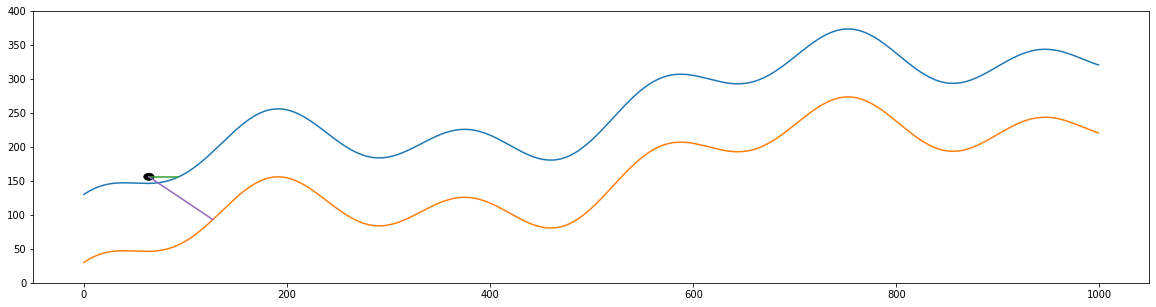

down
Distance center =  27
Distance from left wall =  1
Distance from right wall =  63
tavolsagra van most a felsőtől =  8.684776260001144
tavolsagra van most az alsótól =  108.68477626000114
self.y =  155.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(18, 4)
(18, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.])]
[array([ 81.,  70., 100.,  36.]), array([ 

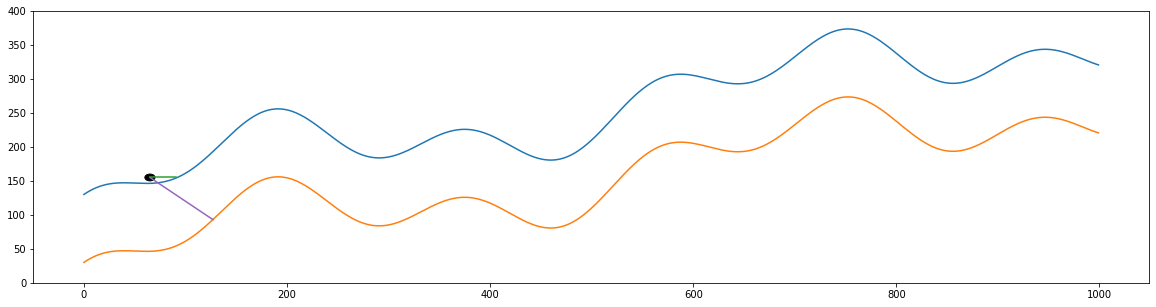

(86, 3)
(86, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(18, 4)
(18, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]), array([101.,  49., 100.,  52.]), ar

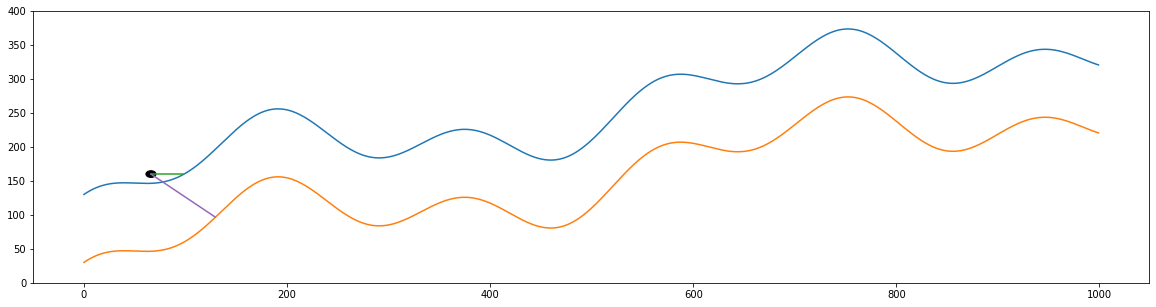

actual _X =  [[ 1 33 64]]
actual predicted =  [[-53.14315231]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(18, 4)
(18, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 10

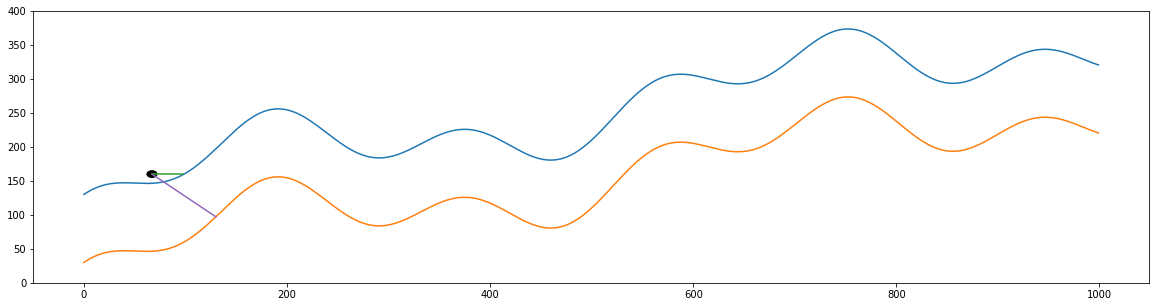

up
Distance center =  32
Distance from left wall =  1
Distance from right wall =  64
tavolsagra van most a felsőtől =  14.481276348654802
tavolsagra van most az alsótól =  114.4812763486548
self.y =  161.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1.]
(19, 4)
(19, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.])]
[array

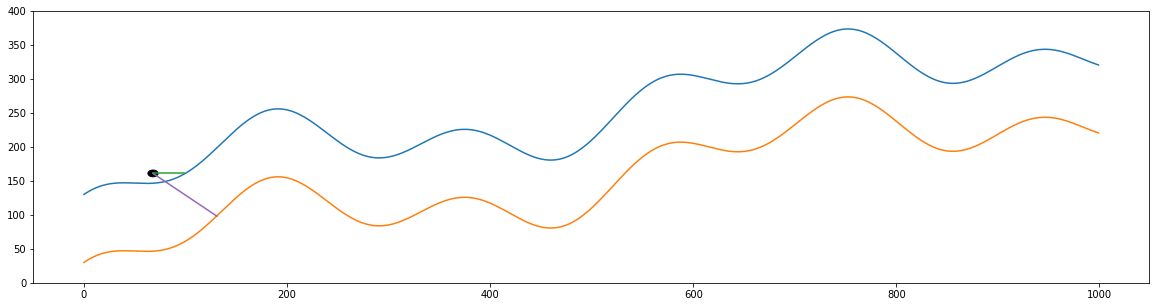

(90, 3)
(90, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1.]
(19, 4)
(19, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  46.]), array([ 95.,  57., 100.,  48.]

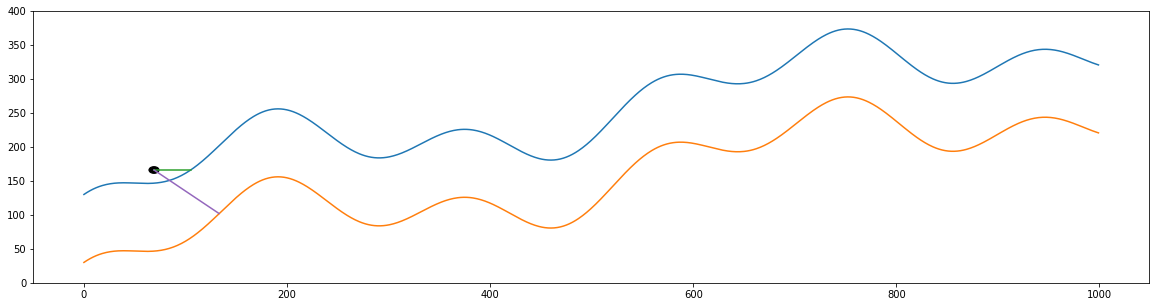

actual _X =  [[ 1 37 65]]
actual predicted =  [[-54.72131475]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1.]
(19, 4)
(19, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62

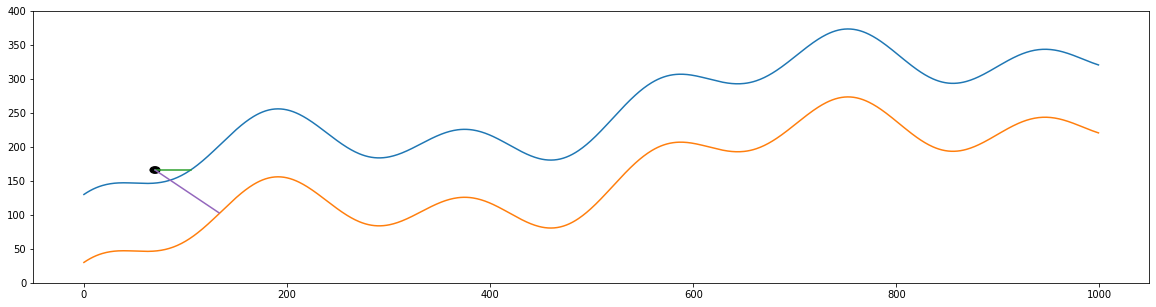

down
Distance center =  34
Distance from left wall =  1
Distance from right wall =  63
tavolsagra van most a felsőtől =  18.12678481280838
tavolsagra van most az alsótól =  118.12678481280838
self.y =  165.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.]
(20, 4)
(20, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), 

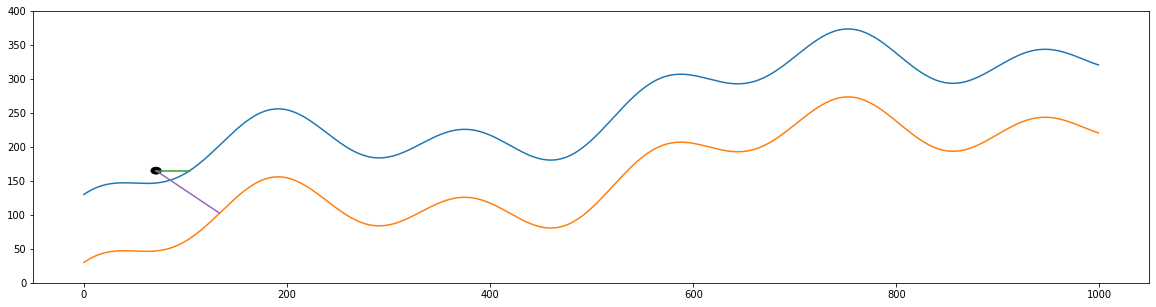

(94, 3)
(94, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.]
(20, 4)
(20, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100.,  40.]), array([ 91.,  62., 100.,  

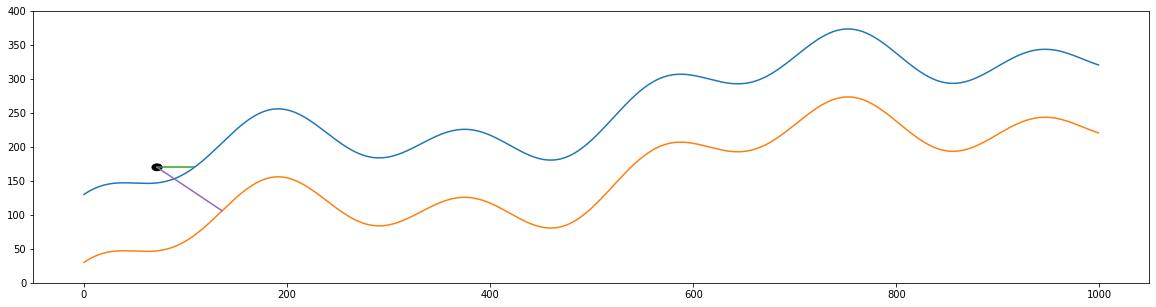

actual _X =  [[ 1 37 65]]
actual predicted =  [[-56.99148808]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.]
(20, 4)
(20, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,

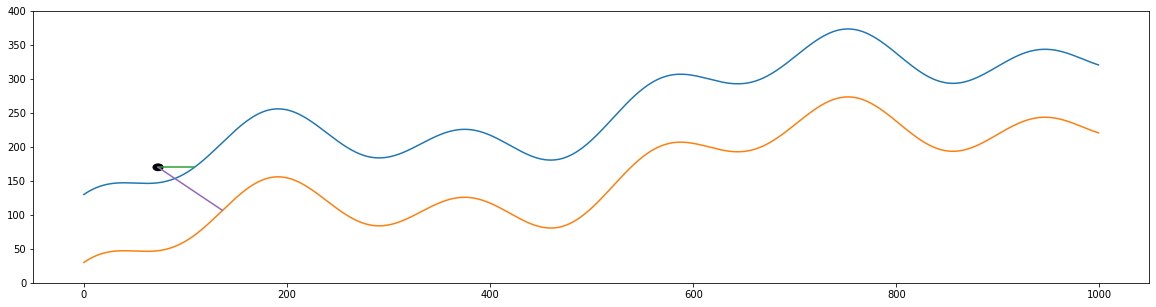

up
Distance center =  36
Distance from left wall =  1
Distance from right wall =  64
tavolsagra van most a felsőtől =  23.600749325892366
tavolsagra van most az alsótól =  123.60074932589237
self.y =  171.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1.]
(21, 4)
(21, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]

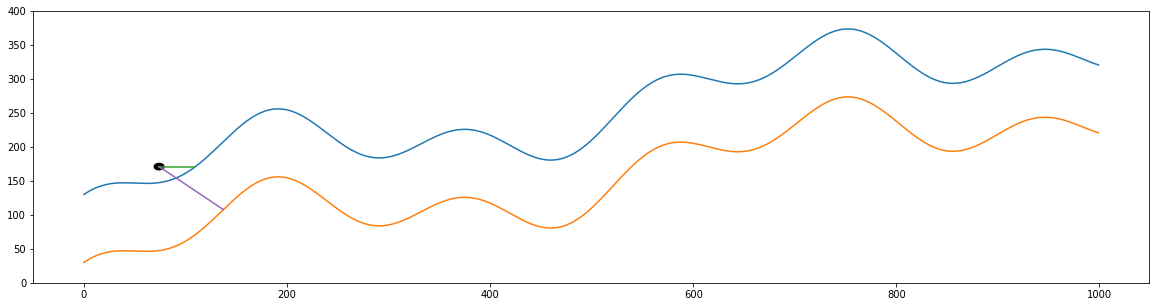

(98, 3)
(98, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1.]
(21, 4)
(21, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82., 100.,  36.]), array([ 85.,  73., 100

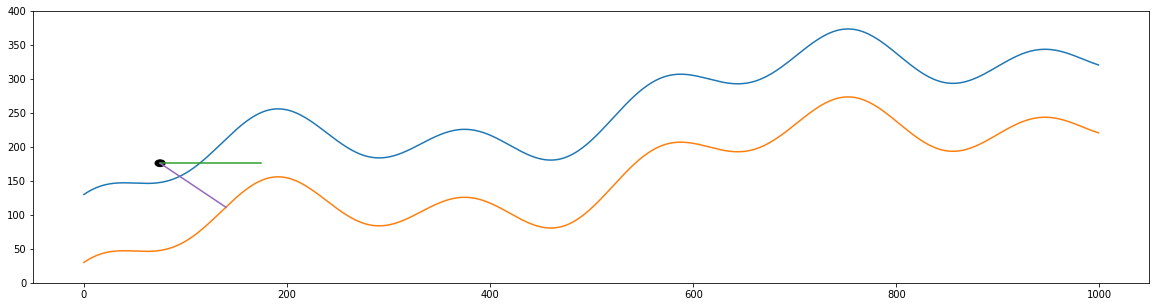

actual _X =  [[  1 100  66]]
actual predicted =  [[-45.46881287]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1.]
(21, 4)
(21, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array

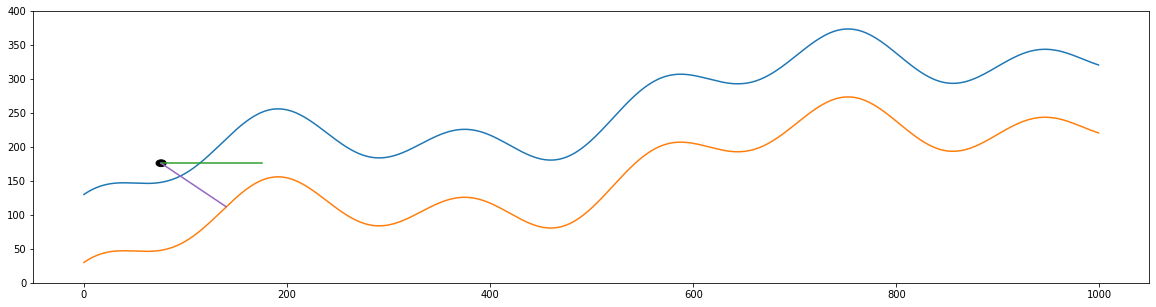

down
Distance center =  37
Distance from left wall =  1
Distance from right wall =  64
tavolsagra van most a felsőtől =  26.884712728025477
tavolsagra van most az alsótól =  126.88471272802548
self.y =  175.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.]
(22, 4)
(22, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,

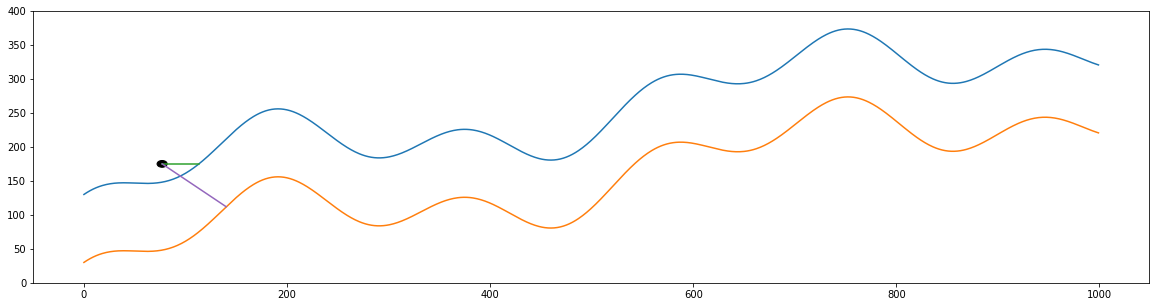

(102, 3)
(102, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.]
(22, 4)
(22, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,  76., 100.,  35.]), array([ 81.,  82

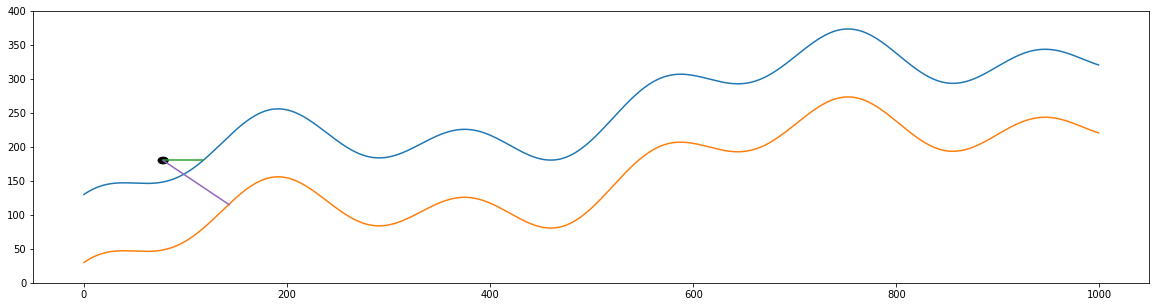

actual _X =  [[ 1 40 66]]
actual predicted =  [[-59.88813604]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.]
(22, 4)
(22, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.])]
[array([ 81.,  70., 100.,  36.]), arra

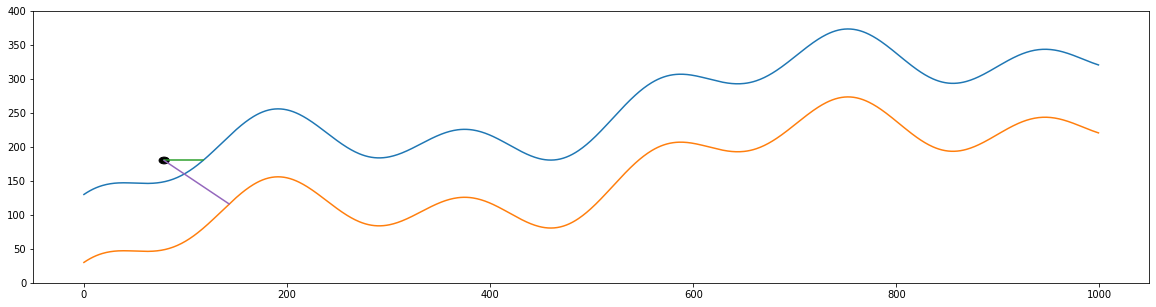

up
Distance from left wall =  1
Distance from right wall =  65
tavolsagra van most a felsőtől =  31.962510075507566
tavolsagra van most az alsótól =  131.96251007550757
self.y =  181.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1.]
(23, 4)
(23, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.

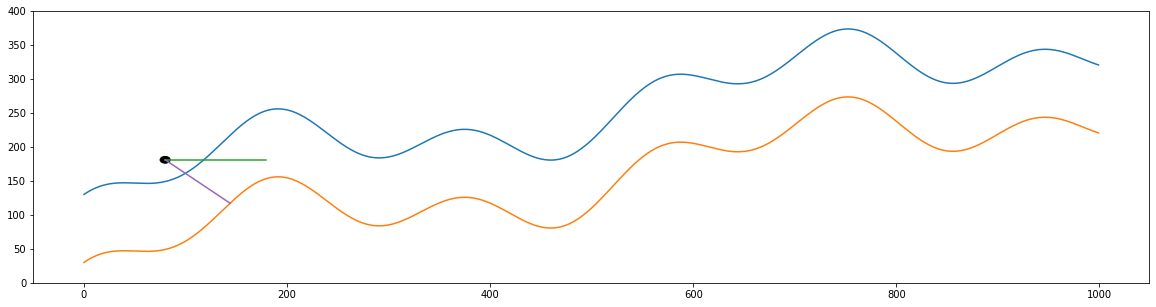

(106, 3)
(106, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1.]
(23, 4)
(23, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([180.,   1.,  39.,  65.])]
[array([ 81.,  70., 100.,  36.]), array([ 80.,

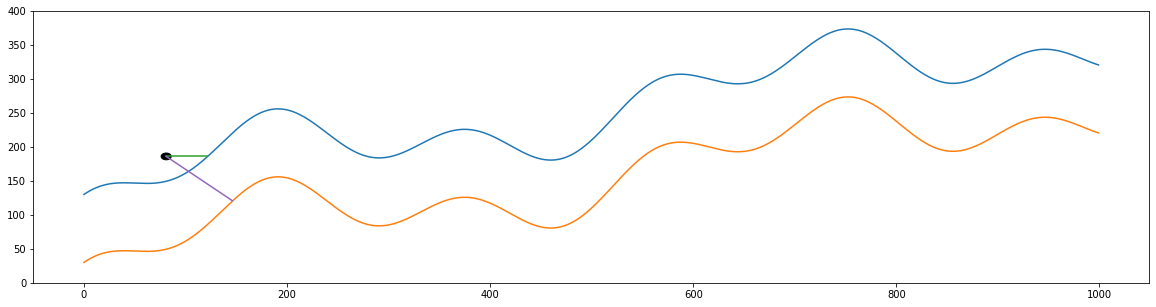

actual _X =  [[ 1 41 66]]
actual predicted =  [[-61.33043792]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1.]
(23, 4)
(23, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([180.,   1.,  39.,  65.])]
[

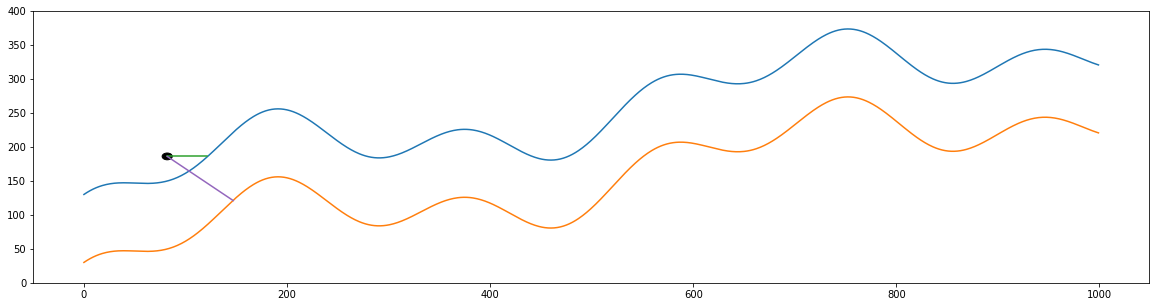

down
Distance from left wall =  1
Distance from right wall =  65
tavolsagra van most a felsőtől =  34.82044237669896
tavolsagra van most az alsótól =  134.82044237669896
self.y =  185.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.]
(24, 4)
(24, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array(

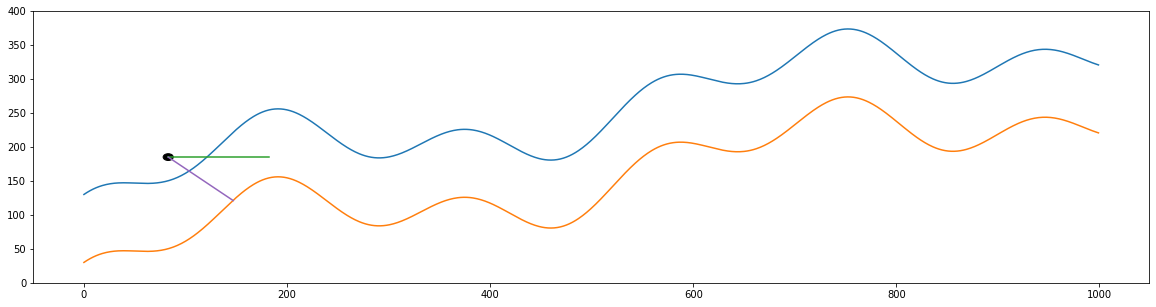

(110, 3)
(110, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.]
(24, 4)
(24, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([180.,   1.,  39.,  65.]), array([186.,   1.,  40.,  66.])]
[array([ 

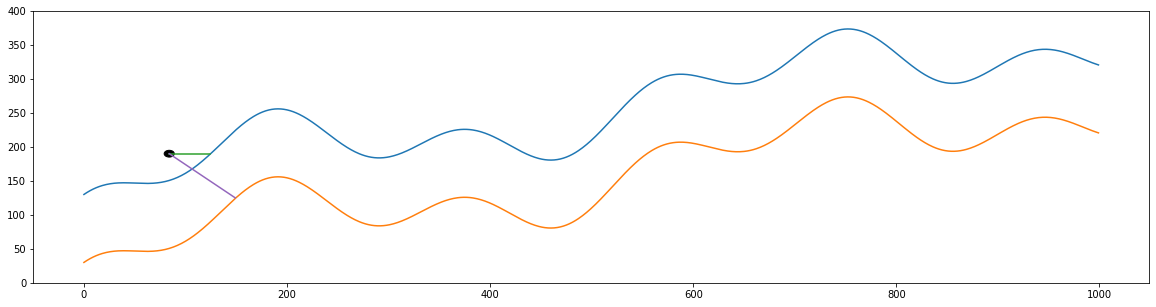

actual _X =  [[ 1 41 66]]
actual predicted =  [[-63.04795894]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.]
(24, 4)
(24, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([180.,   1.,  39.,  65.]

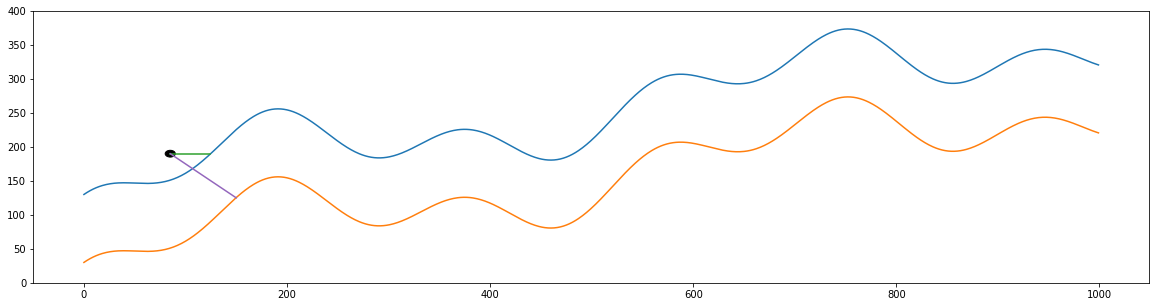

up
Distance center =  40
Distance from left wall =  1
Distance from right wall =  66
tavolsagra van most a felsőtől =  39.44742526582348
tavolsagra van most az alsótól =  139.44742526582348
self.y =  191.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1.]
(25, 4)
(25, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   

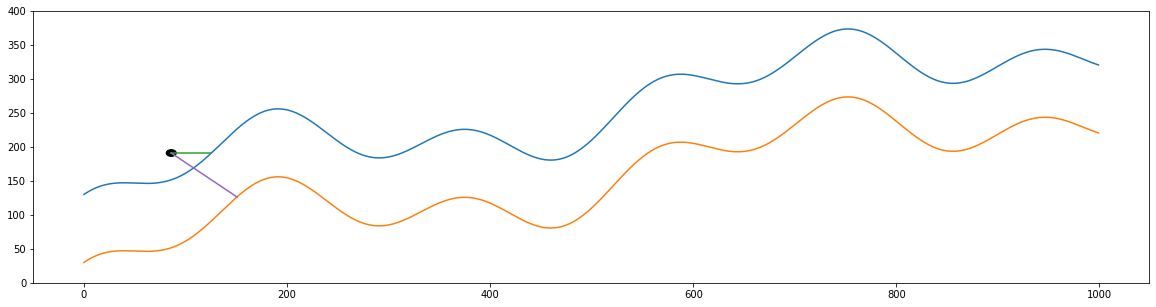

(114, 3)
(114, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1.]
(25, 4)
(25, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([180.,   1.,  39.,  65.]), array([186.,   1.,  40.,  66.]), array

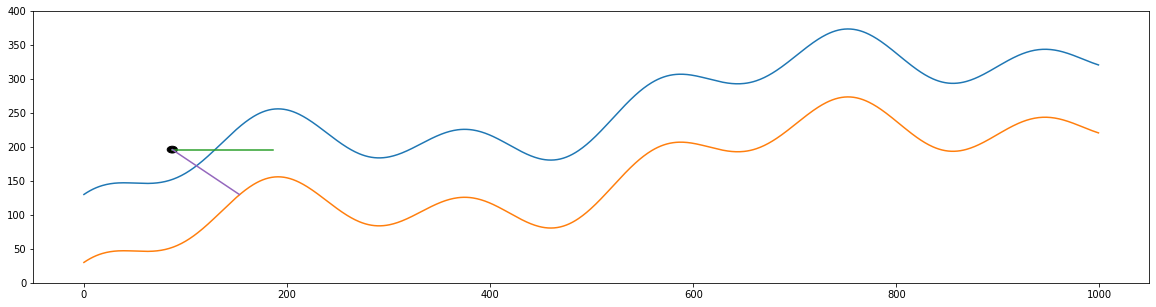

actual _X =  [[  1 100  67]]
actual predicted =  [[-55.75835016]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1.]
(25, 4)
(25, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([180.,   1.,  39.

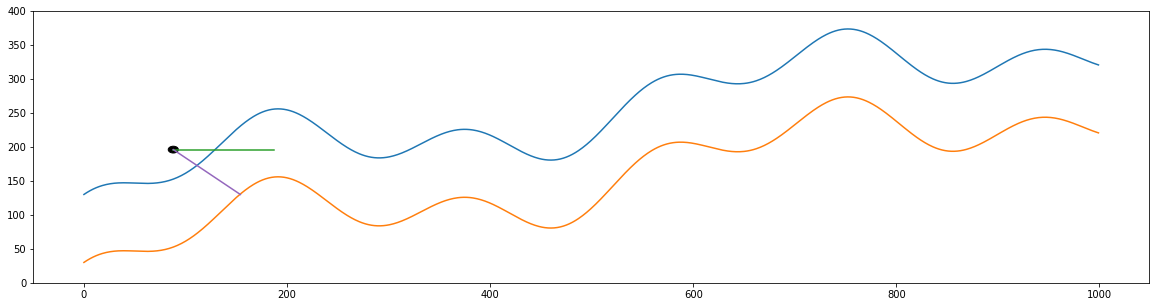

down
Distance center =  40
Distance from left wall =  1
Distance from right wall =  66
tavolsagra van most a felsőtől =  41.83511111710672
tavolsagra van most az alsótól =  141.83511111710672
self.y =  195.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.]
(26, 4)
(26, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([16

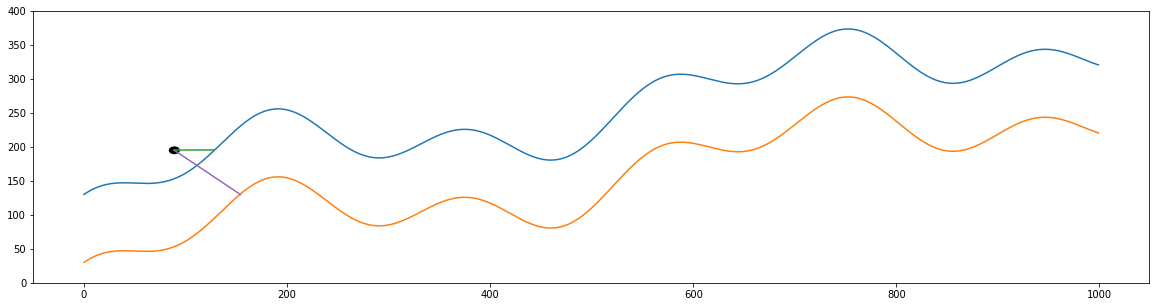

(118, 3)
(118, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.]
(26, 4)
(26, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([180.,   1.,  39.,  65.]), array([186.,   1.,  40.,  66.]), a

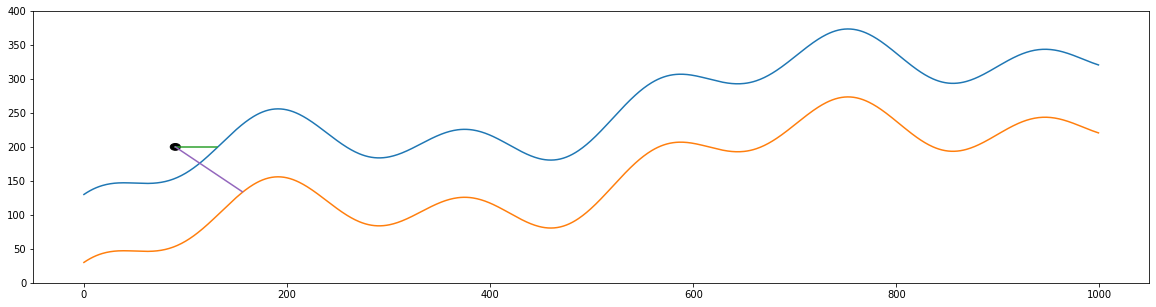

actual _X =  [[ 1 42 67]]
actual predicted =  [[-67.02440104]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.]
(26, 4)
(26, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([180.,   1.,  39

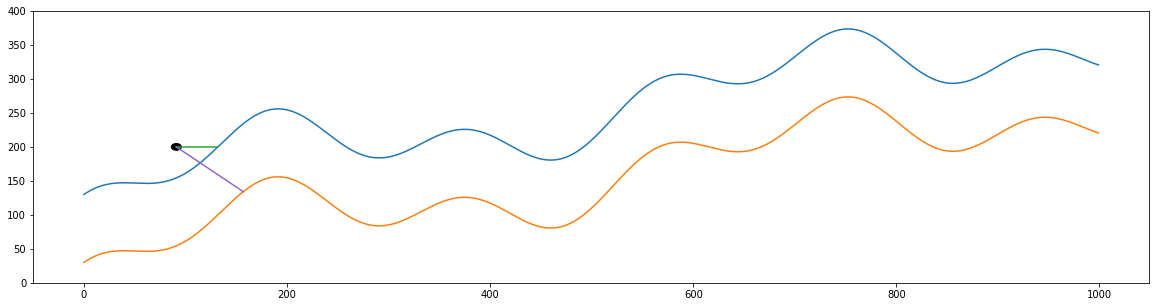

up
Distance center =  41
Distance from left wall =  1
Distance from right wall =  67
tavolsagra van most a felsőtől =  45.977983367512536
tavolsagra van most az alsótól =  145.97798336751254
self.y =  201.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(27, 4)
(27, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array(

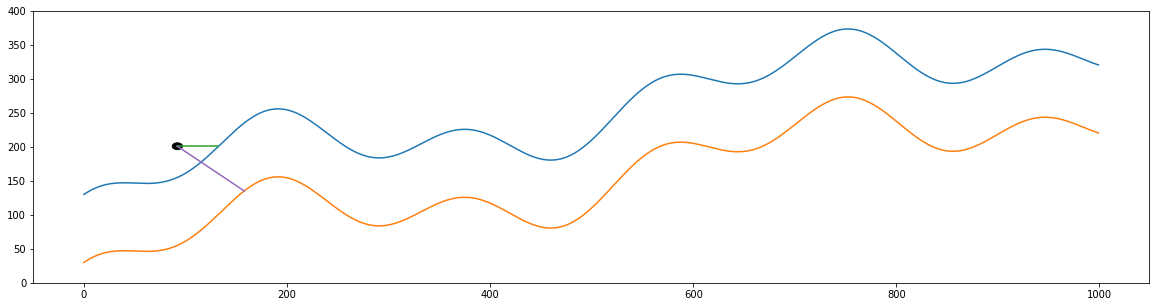

(122, 3)
(122, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(27, 4)
(27, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([180.,   1.,  39.,  65.]), array([186.,   1.,  40.,  66.]

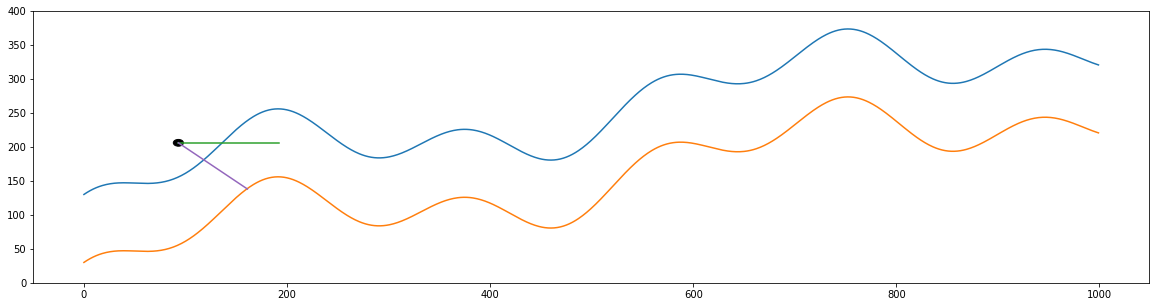

actual _X =  [[  1 100  69]]
actual predicted =  [[-59.39305615]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(27, 4)
(27, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([180.,   

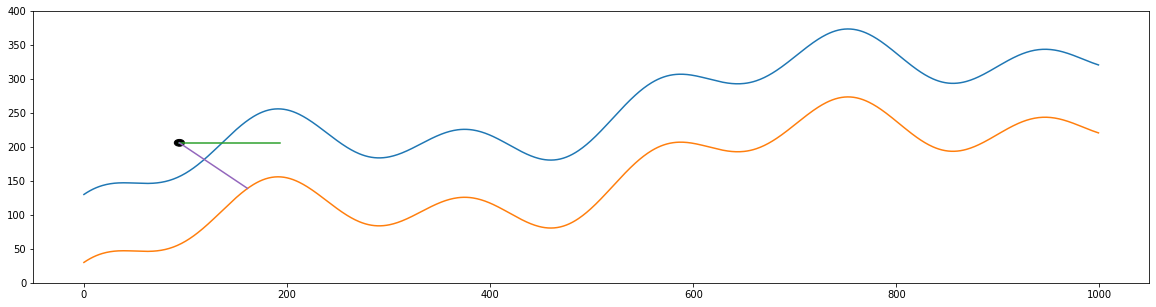

down
Distance center =  41
Distance from left wall =  1
Distance from right wall =  67
tavolsagra van most a felsőtől =  47.87342209451066
tavolsagra van most az alsótól =  147.87342209451066
self.y =  205.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(28, 4)
(28, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), a

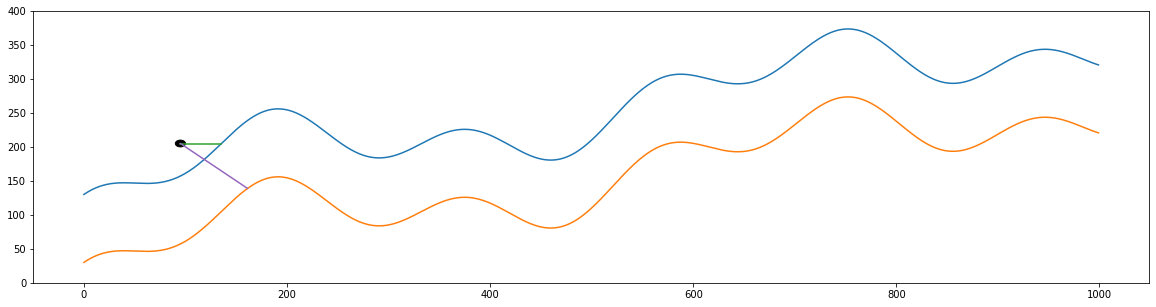

(126, 3)
(126, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(28, 4)
(28, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([180.,   1.,  39.,  65.]), array([186.,   1.,  40.,  

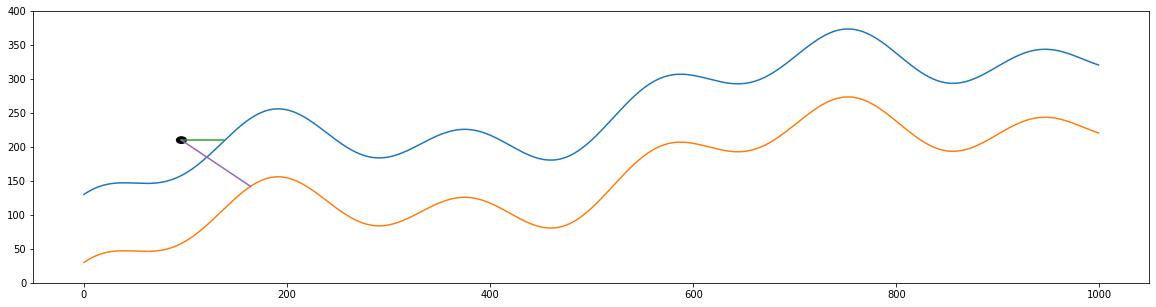

actual _X =  [[ 1 43 69]]
actual predicted =  [[-71.75777513]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(28, 4)
(28, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([180.,  

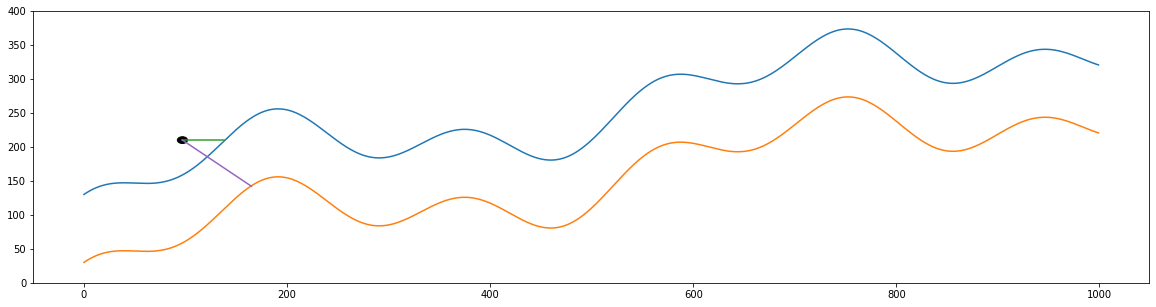

up
Distance center =  42
Distance from left wall =  1
Distance from right wall =  69
tavolsagra van most a felsőtől =  51.521740183018835
tavolsagra van most az alsótól =  151.52174018301884
self.y =  211.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(29, 4)
(29, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.])

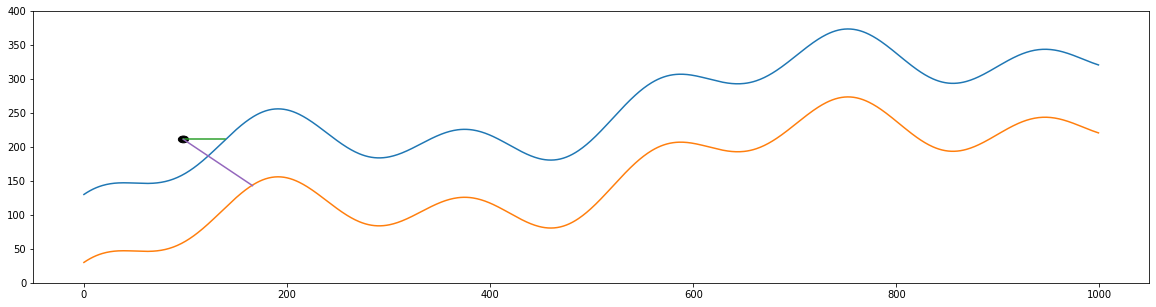

(130, 3)
(130, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(29, 4)
(29, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([180.,   1.,  39.,  65.]), array([186.,   1.,  40

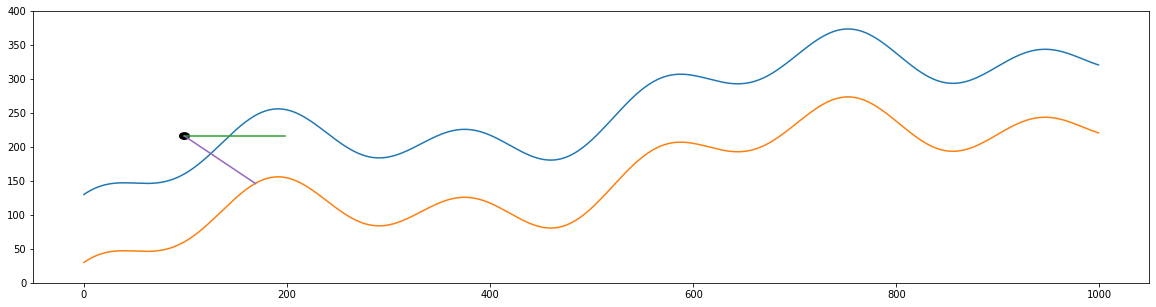

actual _X =  [[  1 100  71]]
actual predicted =  [[-64.98402713]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(29, 4)
(29, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([

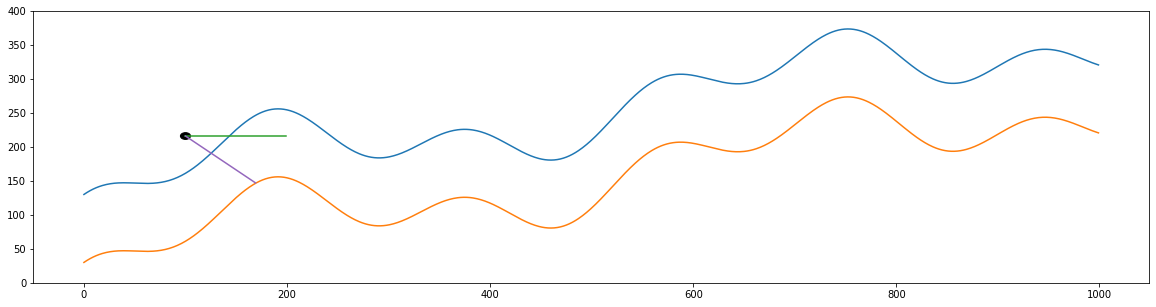

down
Distance center =  42
Distance from left wall =  1
Distance from right wall =  69
tavolsagra van most a felsőtől =  52.926189710038045
tavolsagra van most az alsótól =  152.92618971003805
self.y =  215.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(30, 4)
(30, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30., 

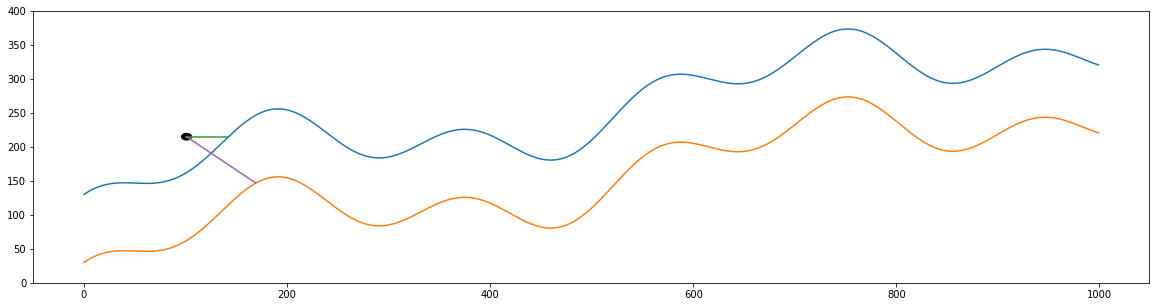

(134, 3)
(134, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(30, 4)
(30, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([180.,   1.,  39.,  65.]), array([186.,   1.,

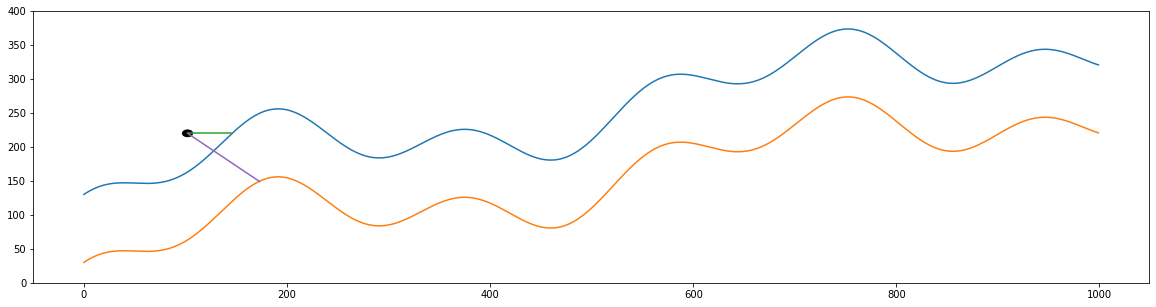

actual _X =  [[ 1 44 72]]
actual predicted =  [[-79.89345713]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(30, 4)
(30, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array(

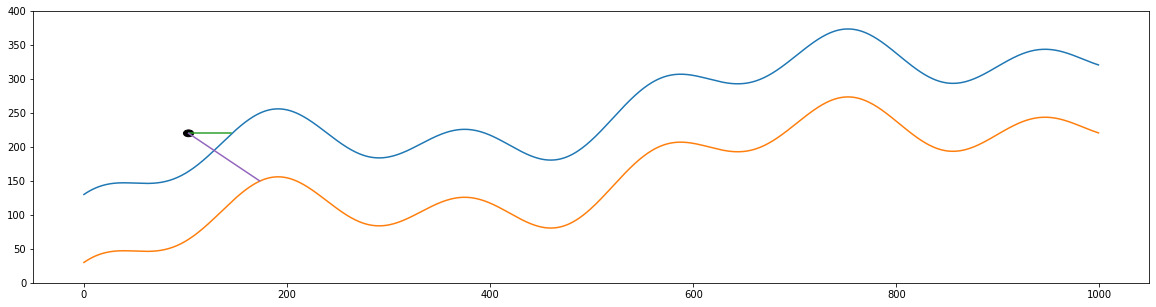

up
Distance center =  43
Distance from left wall =  1
Distance from right wall =  72
tavolsagra van most a felsőtől =  56.09293847359686
tavolsagra van most az alsótól =  156.09293847359686
self.y =  221.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(31, 4)
(31, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,

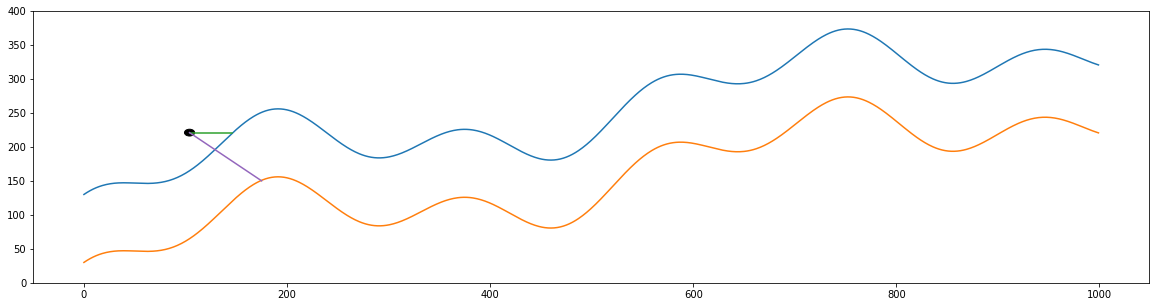

(138, 3)
(138, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(31, 4)
(31, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([180.,   1.,  39.,  65.]), array([186.,  

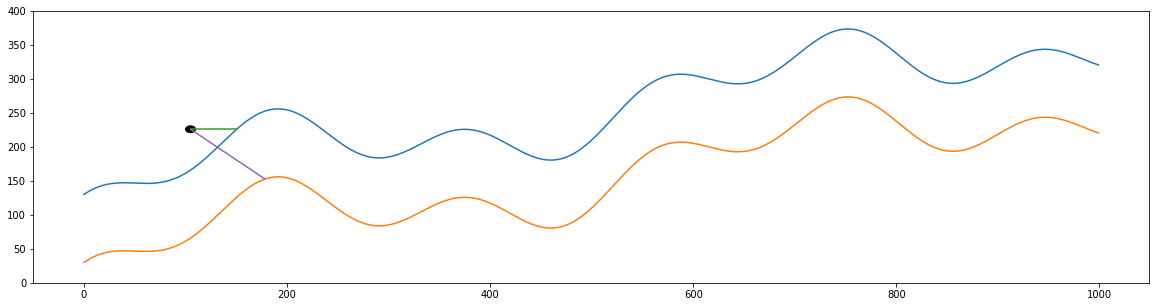

actual _X =  [[ 1 46 74]]
actual predicted =  [[-86.19684636]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(31, 4)
(31, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), ar

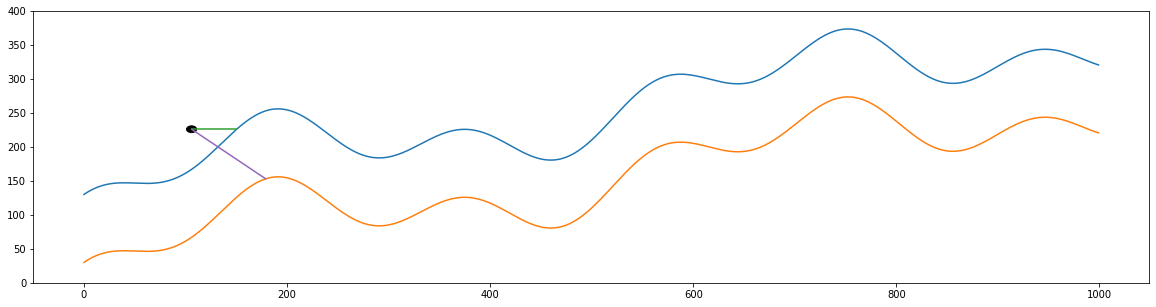

down
Distance center =  43
Distance from left wall =  1
Distance from right wall =  73
tavolsagra van most a felsőtől =  57.031016891461945
tavolsagra van most az alsótól =  157.03101689146195
self.y =  225.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(32, 4)
(32, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.

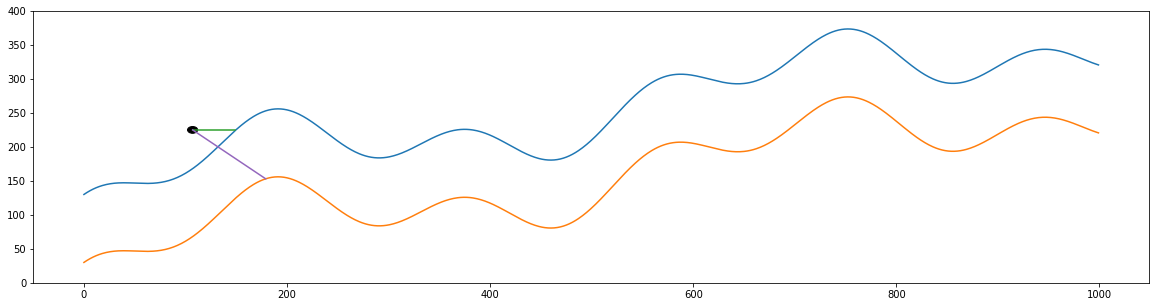

(142, 3)
(142, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(32, 4)
(32, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([180.,   1.,  39.,  65.]), array([186

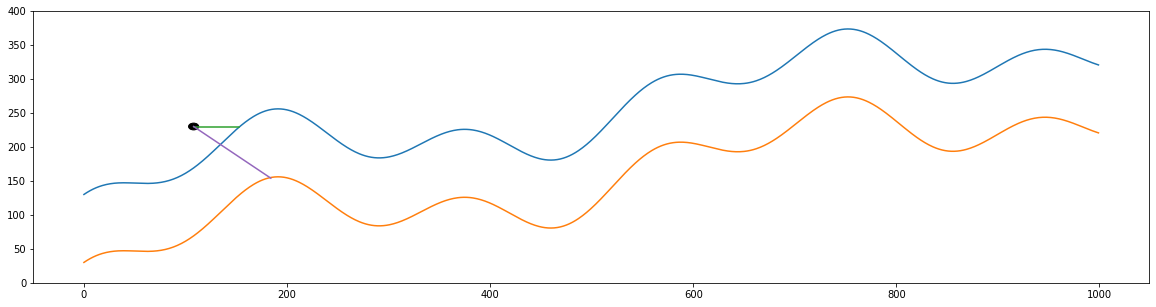

actual _X =  [[ 1 46 77]]
actual predicted =  [[-95.23932887]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(32, 4)
(32, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.])

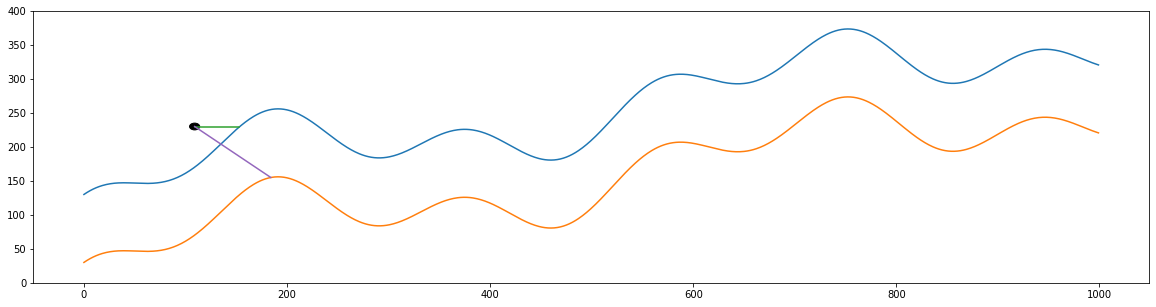

up
Distance center =  45
Distance from left wall =  1
Distance from right wall =  77
tavolsagra van most a felsőtől =  59.75223579167056
tavolsagra van most az alsótól =  159.75223579167056
self.y =  231.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(33, 4)
(33, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1

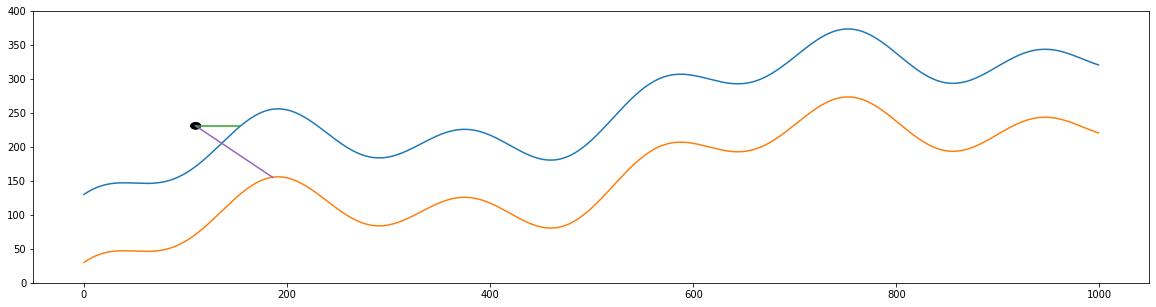

(146, 3)
(146, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(33, 4)
(33, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([180.,   1.,  39.,  65.]), array(

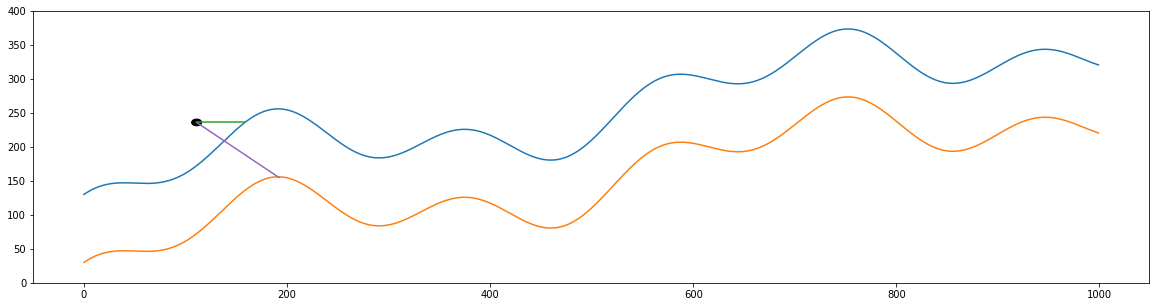

actual _X =  [[ 1 48 82]]
actual predicted =  [[-107.9089971]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(33, 4)
(33, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  6

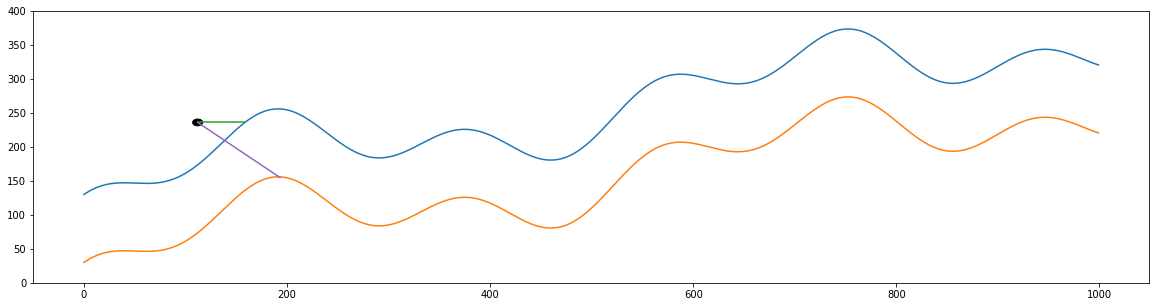

down
Distance center =  45
Distance from left wall =  1
Distance from right wall =  81
tavolsagra van most a felsőtől =  60.271075908331795
tavolsagra van most az alsótól =  160.2710759083318
self.y =  235.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(34, 4)
(34, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156

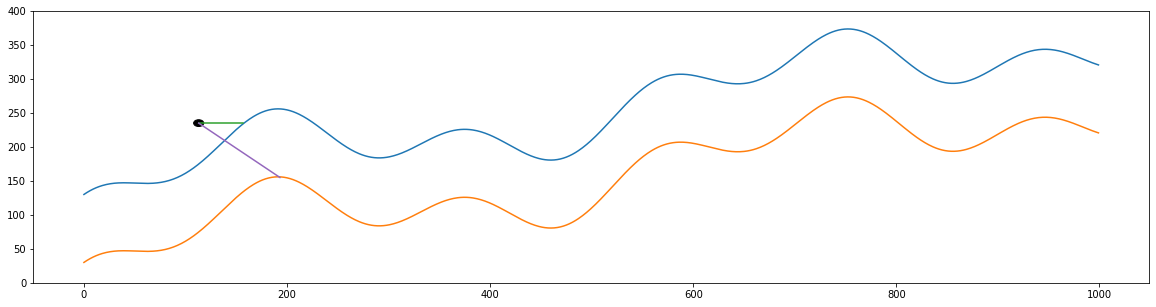

(150, 3)
(150, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(34, 4)
(34, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([180.,   1.,  39.,  65.]), ar

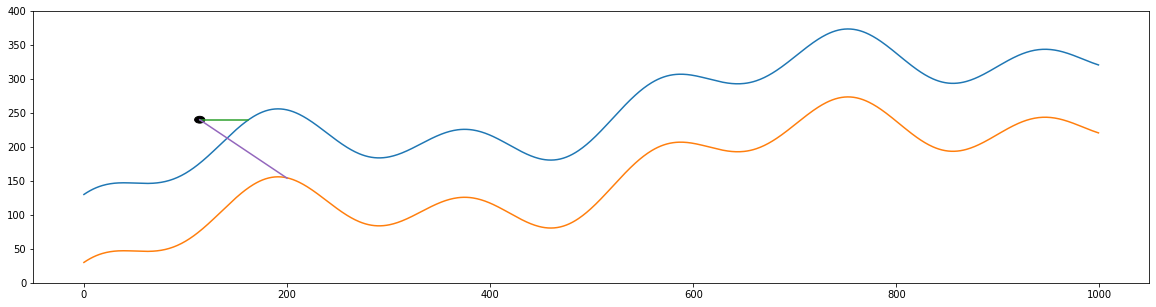

actual _X =  [[ 1 49 87]]
actual predicted =  [[-118.95403504]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(34, 4)
(34, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100

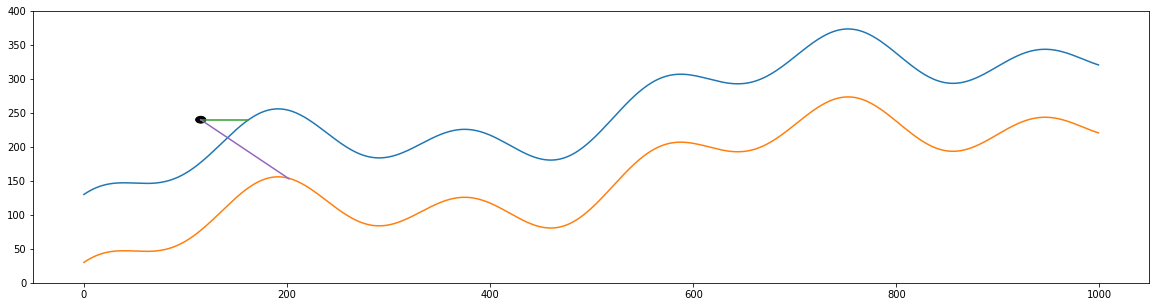

up
Distance center =  48
Distance from left wall =  1
Distance from right wall =  91
tavolsagra van most a felsőtől =  62.60455017941524
tavolsagra van most az alsótól =  162.60455017941524
self.y =  241.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(35, 4)
(35, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([1

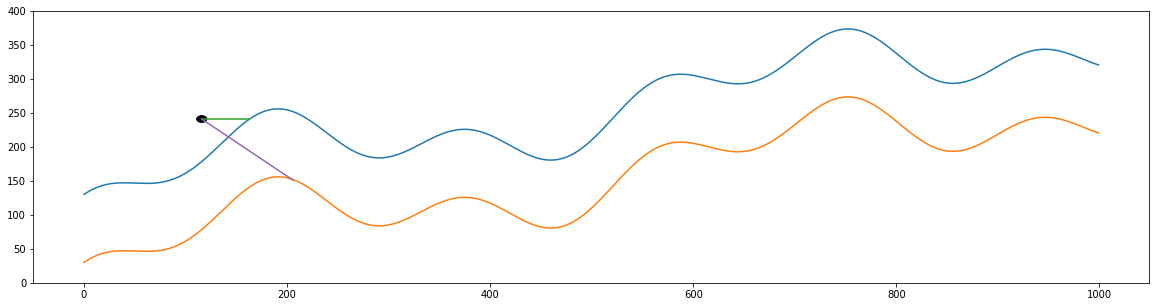

(154, 3)
(154, 1)
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(35, 4)
(35, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   1., 100.,  65.]), array([180.,   1.,  39.,  65.])

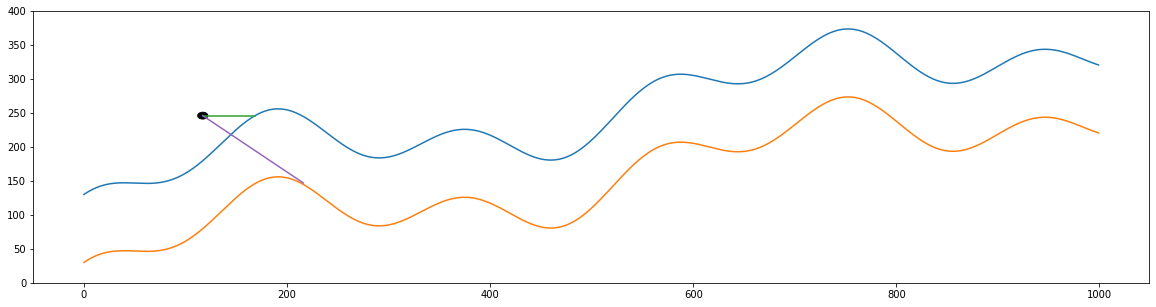

actual _X =  [[  1  52 100]]
actual predicted =  [[-137.44728675]]
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
(35, 4)
(35, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), array([160.,   1.,  32.,  64.]), array([166.,   1.,  36.,  64.]), array([170.,   1.,  36.,  64.]), array([176.,   

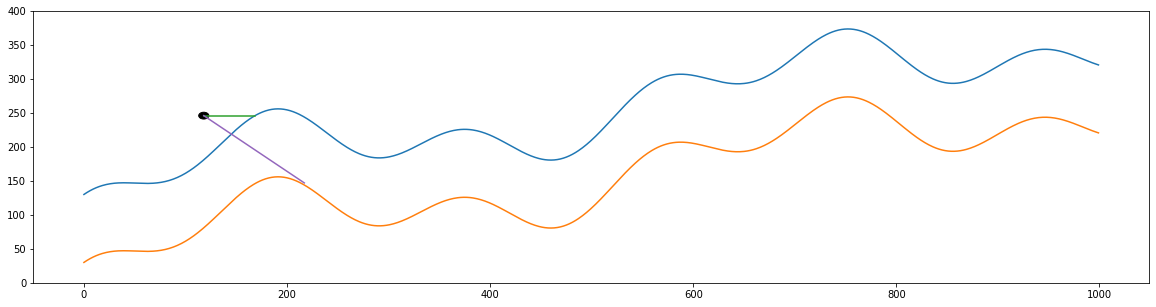

down
Distance center =  49
Distance from left wall =  1
tavolsagra van most a felsőtől =  62.77204021556901
tavolsagra van most az alsótól =  162.772040215569
self.y =  245.0
Van elég before after adatunk
--------------------------------------
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
(36, 4)
(36, 4)
[array([ 80.,  71., 100.,  35.]), array([ 81.,  72., 100.,  36.]), array([80., 83., 99., 35.]), array([ 86.,  68., 100.,  41.]), array([ 90.,  63., 100.,  45.]), array([ 96.,  54., 100.,  49.]), array([100.,  50., 100.,  52.]), array([106.,  42., 100.,  55.]), array([110.,  38., 100.,  56.]), array([116.,  31., 100.,  58.]), array([120.,  27., 100.,  59.]), array([126.,  21., 100.,  61.]), array([130.,  17., 100.,  61.]), array([136.,  11., 100.,  62.]), array([140.,   7., 100.,  62.]), array([146.,   1.,   1.,  63.]), array([150.,   1.,  22.,  63.]), array([156.,   1.,  30.,  64.]), ar

In [159]:
auto.run()

In [ ]:
for i in range(0, 100, 1):
  auto.calculate_distances()
  auto.plot()
  auto.x = i


  # tulajdonképpen itt jön majd a logika miszerint,
  #
  # 1 veszünk egy neurális hálót
  # bemenetek a faltól mért távolságok a szezorok alapján, kimenet a ratio (vagyis, hogy milyen aránban mennyire van a faltól)
  # a ratiót még át kell állítanom úgy, hogy pozitív és negatív értéke is legyen
  #
  # minden lépés után újra tanítjuk a hálót
  # miden második lépésben viszont azt csináljuk, hogy felfelé lépünk egyet az y tengelyen vagy lefele és megnézzük, hogy ennek
  # hatására, hogy változott a szenzoros adat.
  #
  # egy harmadik lépésben pedig azt csináljuk, hogy 50 mérés után
  #
  # kiszámoljuk a szenzoros adatokból a before after adatok alapján, a lineáris regressziós modelt minden egyes metrikára
  #
  # ha megvan ez a modell, akkor
  #
  # 4 lépésben kiszámoljuk, hogy mi lenne a szenzor új értéke 1,2,3,4,5,... stb le, vagy fel lépés esetén
  #
  # 5 mindegyik esetben behelyettesítjük a neurális hálóba és végig nézzük, hogy milyen kimenete lenne (ne feledjük, hogy a középponhoz való közelséget mérjük)
  # azt az megoldást választjuk, ami a legközelebb viszi a középponthoz
  #
  # 6 ténylegesen módosítunk a kocsi y értékén méghozzá annyival amit a rendszer mond

<a name="irodalom"></a>

# Felhasznált irodalom és internetes cimek

Itt gyűjtöttem össze a menet közben összegyűjt okosságokat

[vissza a tartalomhoz](#tartalom)<br>

Scikit-learn - MLPRegressor API
<br>
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html


Fogalmak és probléma meghatározás
<br>
https://www.rubrik.com/blog/architecture/20/12/customized-autoscaling--minimize-your-cloud-cost


https://github.com/kubernetes/autoscaler/blob/master/cluster-autoscaler/FAQ.md#what-are-the-parameters-to-ca

https://arxiv.org/pdf/1608.04030.pdf

Metrikák amivel a szollgáltatás minőségét mérik különböző esetekben
<br>
https://blog.avinetworks.com/autoscaling-metrics

------------

NumPy API Reference Guide
<br>
https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html


Seaborn API Reference Guide
<br>
https://seaborn.pydata.org/examples/pair_grid_with_kde.html

